In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az
from scipy.interpolate import griddata
import pymc3 as pm
from patsy import bs

In [2]:
%config InlineBackend.figure_format='retina'

# Geocentric Models

## Codes 

### Code 4.1

In [3]:
pos = np.array([np.random.uniform(low=-1, high=1, size=16).sum() for _ in range(1000)])

<AxesSubplot:ylabel='Density'>

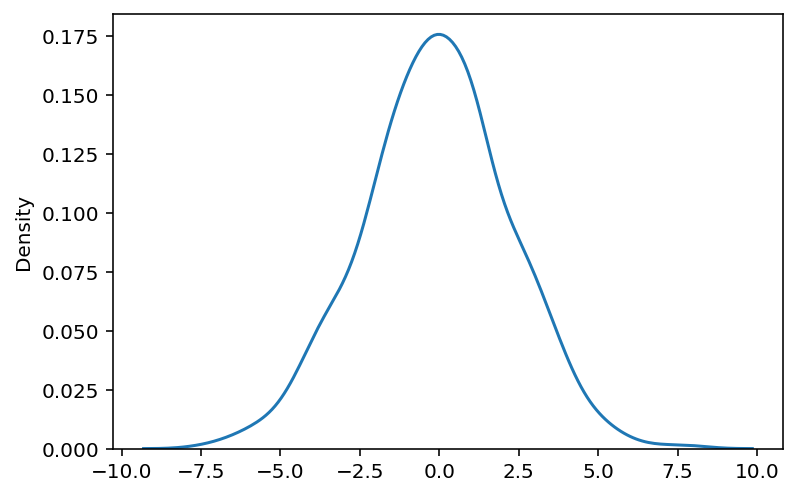

In [4]:
sns.kdeplot(pos)

### Code 4.2

In [5]:
(1 + np.random.uniform(low=0, high=.1, size=12)).prod()

1.5462880344043204

### Code 4.3

In [6]:
pos = np.array([(1 + np.random.uniform(low=0, high=.1, size=12)).prod() for _ in range(1000)])

<AxesSubplot:ylabel='Density'>

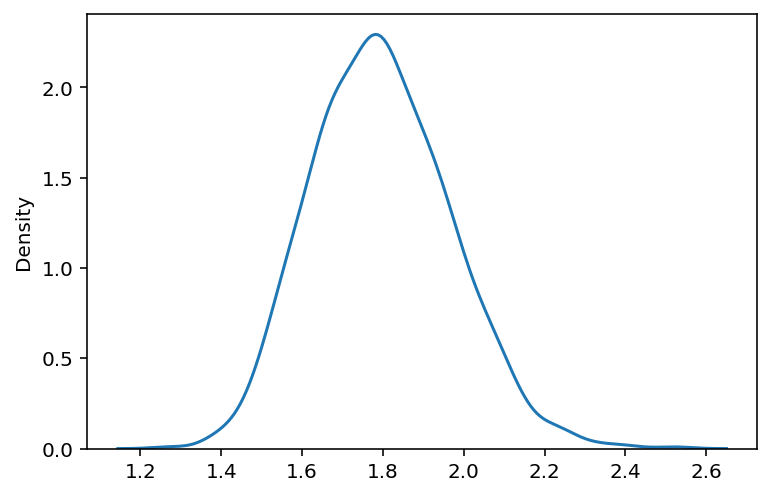

In [7]:
sns.kdeplot(pos)

### Code 4.4

<AxesSubplot:ylabel='Density'>

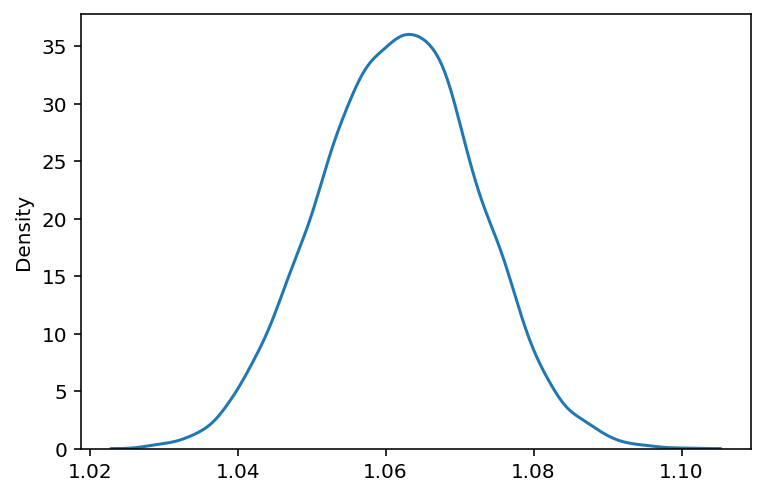

In [8]:
small = (1 + np.random.uniform(low=0, high=.01, size=(12, 10000))).prod(axis=0)
sns.kdeplot(small)

<AxesSubplot:ylabel='Density'>

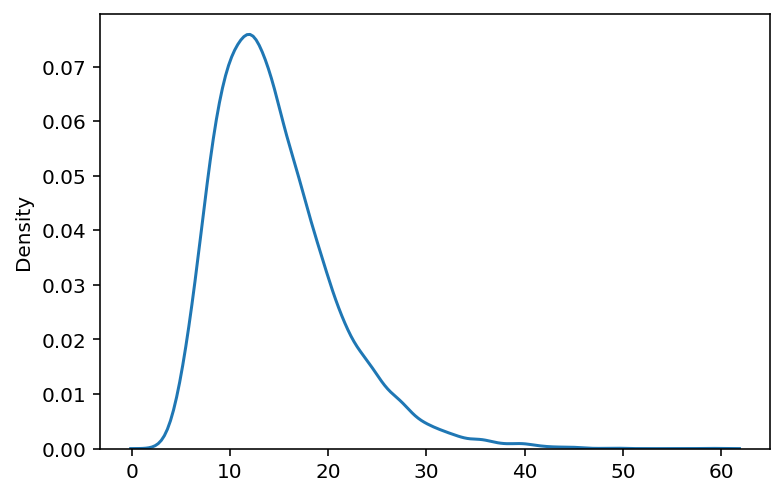

In [9]:
big = (1 + np.random.uniform(low=0, high=.5, size=(12, 10000))).prod(axis=0)
sns.kdeplot(big)

### Code 4.5

<AxesSubplot:ylabel='Density'>

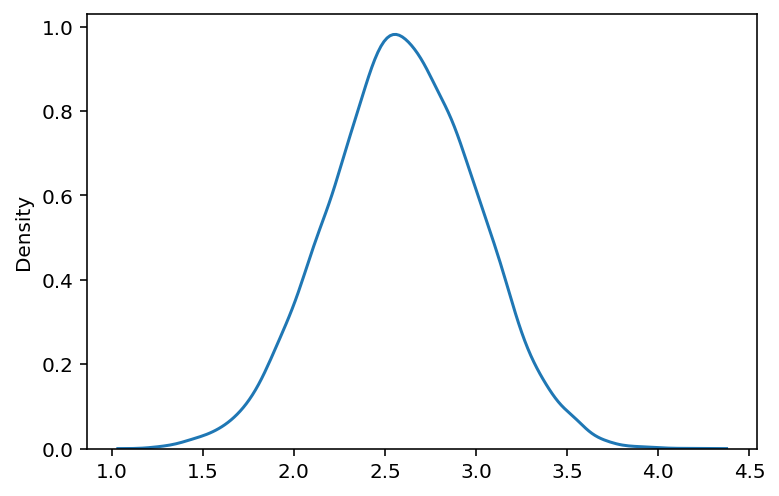

In [10]:
logbig = np.log((1 + np.random.uniform(low=0, high=.5, size=(12, 10000))).prod(axis=0))
sns.kdeplot(logbig)

### Code 4.6

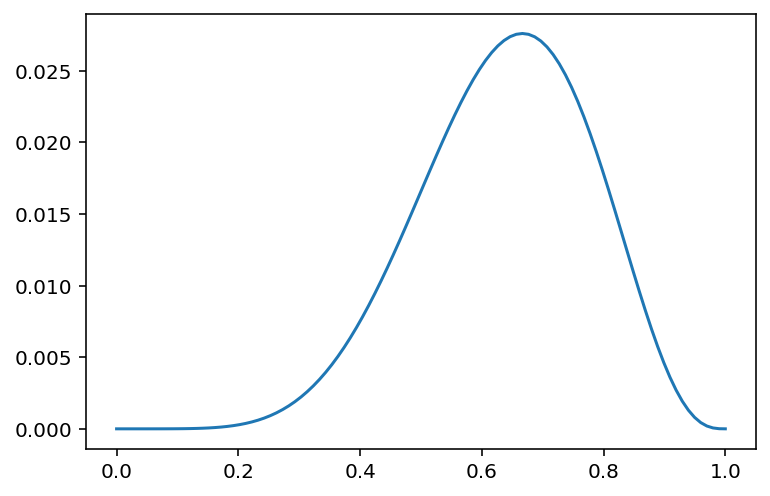

In [11]:
w = 6
n = 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior/posterior.sum()

plt.plot(p_grid, posterior)
plt.show()

### Code 4.7

In [12]:
d = pd.read_csv("../../data/Howell1.csv", sep=';')

### Code 4.8

In [13]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

### Code 4.9

In [14]:
d.describe(percentiles=[.055, .945])

height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
5.5%    81.108550    9.360721    1.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
94.5%  165.735000   54.502894   66.135000    1.000000
max    179.070000   62.992589   88.000000    1.000000

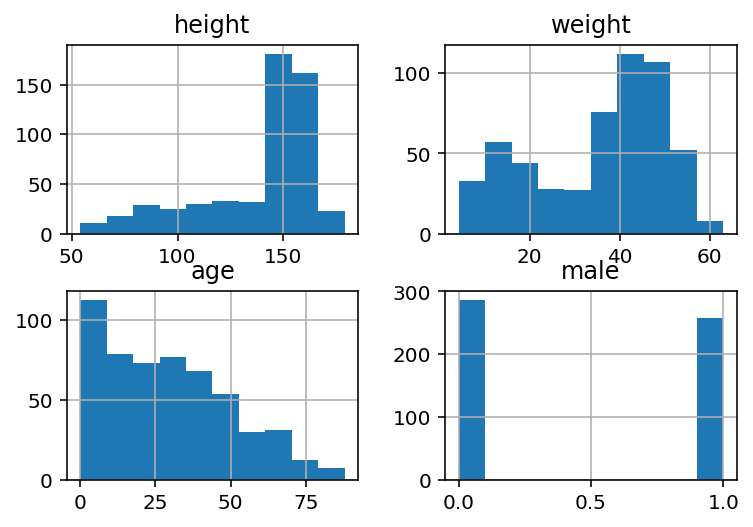

In [15]:
d.hist()
plt.show()

### Code 4.10

In [16]:
d['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

### Code 4.11

In [17]:
d2 = d[d['age'] >= 18].reset_index(drop=True)
d2.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

### Code 4.12

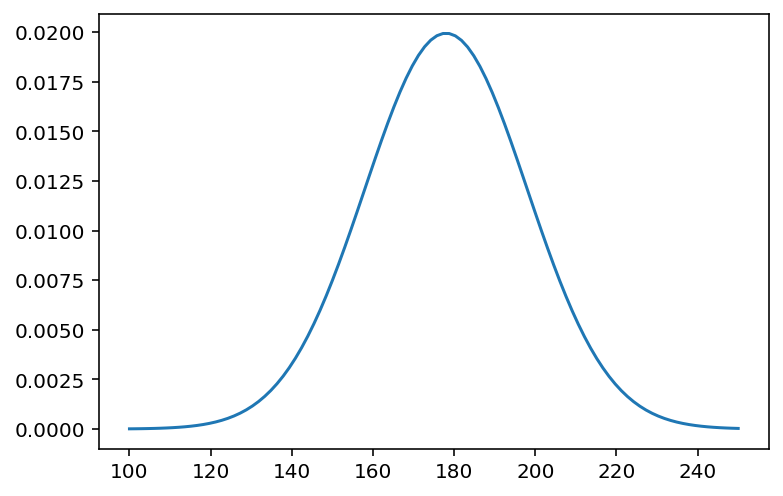

In [18]:
xgrid = np.linspace(start=100, stop=250, num=100)
ygrid = stats.norm(178, 20).pdf(xgrid)
plt.plot(xgrid, ygrid)
plt.show()

### Code 4.13

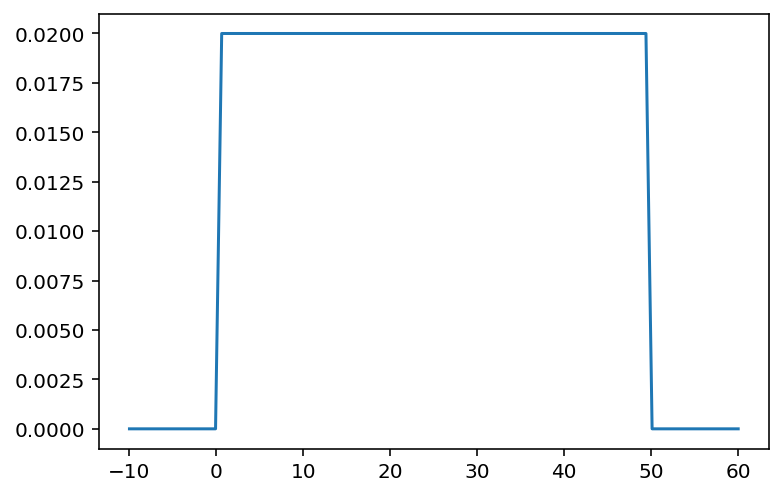

In [19]:
xgrid = np.linspace(start=-10, stop=60, num=100)
ygrid = stats.uniform(0, 50).pdf(xgrid)
plt.plot(xgrid, ygrid)
plt.show()

### Code 4.14

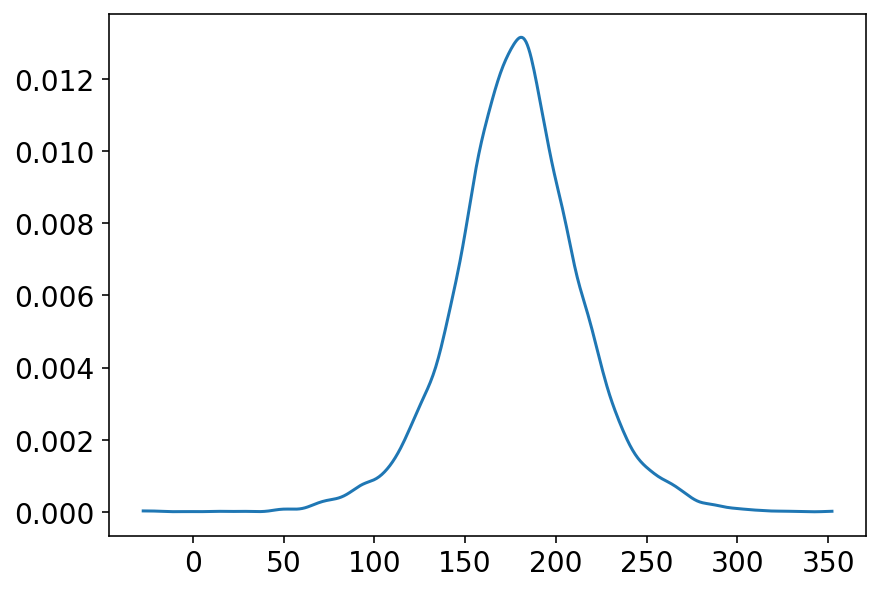

In [20]:
sample_mu = stats.norm(178, 20).rvs(10000)
sample_sigma = stats.uniform(0, 50).rvs(10000)
prior_h = stats.norm(sample_mu, sample_sigma).rvs()
az.plot_kde(prior_h)
plt.show()

### Code 4.15

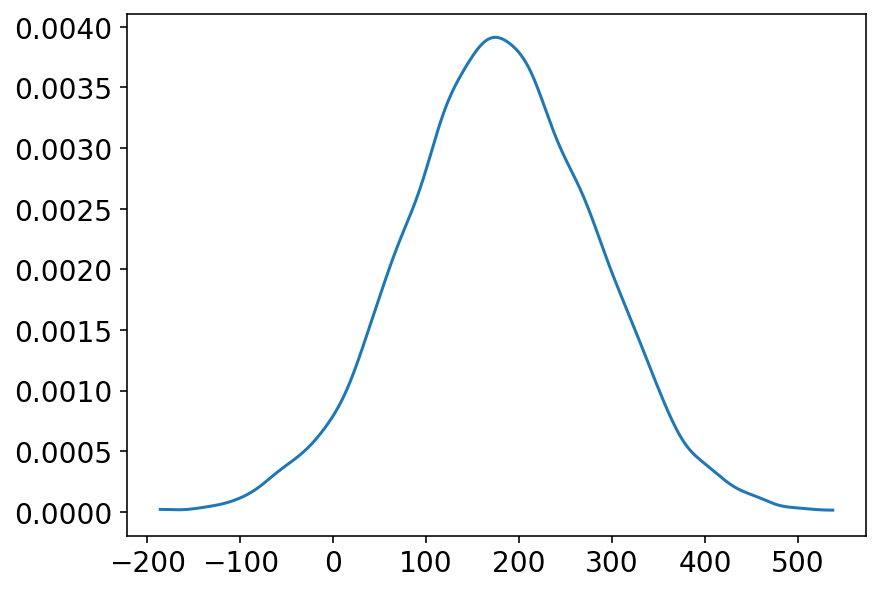

In [21]:
sample_mu = stats.norm(178, 100).rvs(10000)
sample_sigma = stats.uniform(0, 50).rvs(10000)
prior_h = stats.norm(sample_mu, sample_sigma).rvs()
az.plot_kde(prior_h)
plt.show()

### Code 4.16

In [22]:
mu_list = np.linspace(150, 160, 100)
sigma_list = np.linspace(7, 9, 100)
post = np.array(np.meshgrid(mu_list, sigma_list)).reshape(2, -1).T

In [23]:
likelihood = []
for i in range(len(post)):
    x = stats.norm(loc=post[i, 0], scale=post[i, 1]).logpdf(d2['height']).sum()
    likelihood.append(x)
    
likelihood = np.array(likelihood)

In [24]:
post_prob = likelihood + \
    stats.norm(loc=178, scale=20).logpdf(post[:, 0]) + \
    stats.uniform(loc=0, scale=50).logpdf(post[:, 1])

In [25]:
post_prob = np.exp(post_prob - post_prob.max())

### Code 3.17

In [26]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

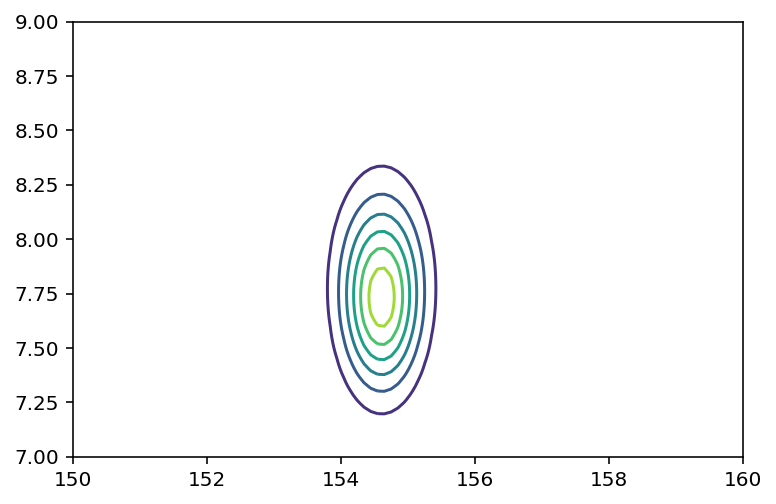

In [27]:
plt.contour(xi, yi, zi);
plt.show()

### Code 4.18

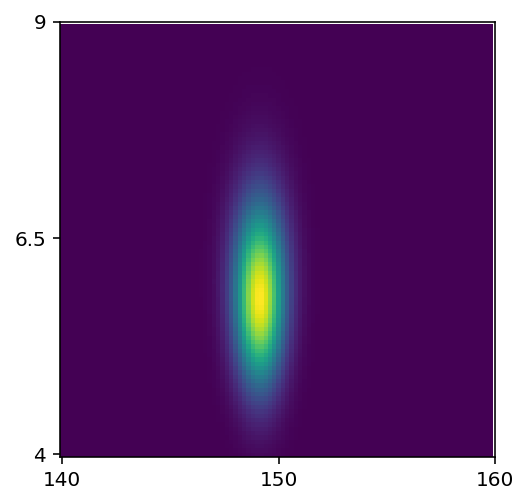

In [28]:
_, ax = plt.subplots()
ax.imshow(zi, origin="lower")
ax.set_xticks([0, 50, 100])
ax.set_xticklabels([140, 150, 160])
ax.set_yticks([0, 50, 100])
ax.set_yticklabels([4, 6.5, 9])
ax.grid(False);

### Code 4.19

In [29]:
sample_rows = np.random.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

### Code 4.20

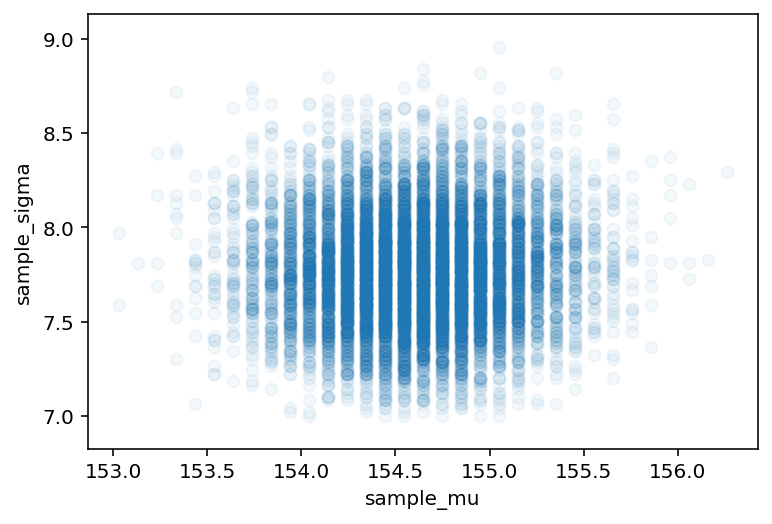

In [30]:
plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

### Code 4.21

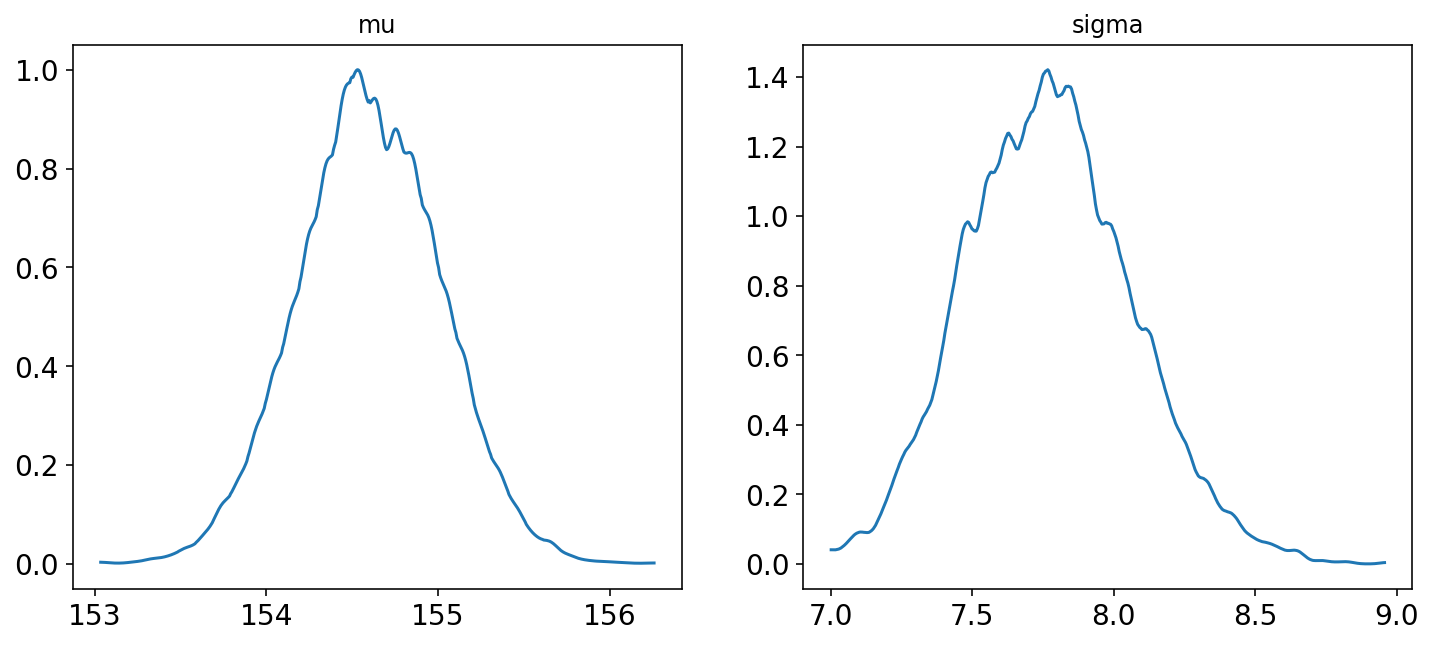

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

az.plot_kde(sample_mu, ax=ax1, bw=.05)
az.plot_kde(sample_sigma, ax=ax2)

ax1.set_title('mu')
ax2.set_title('sigma')
plt.show()

### Code 4.22

In [32]:
az.hdi(sample_mu, hdi_prob=.89)

array([153.83838384, 155.15151515])

In [33]:
az.hdi(sample_sigma, hdi_prob=.89)

array([7.24242424, 8.17171717])

### Code 4.23

In [34]:
d3 = np.random.choice(d2['height'], size=20)

In [35]:
d3

array([152.4  , 147.955, 160.655, 165.989, 160.655, 157.48 , 149.225,
       157.48 , 150.495, 152.4  , 160.7  , 159.385, 155.575, 163.83 ,
       147.32 , 157.48 , 168.91 , 157.48 , 166.37 , 161.925])

### Code 4.24

In [36]:
mu_list = np.linspace(150, 170, 200)
sigma_list = np.linspace(4, 20, 200)
post = np.array(np.meshgrid(mu_list, sigma_list)).reshape(2, -1).T

In [37]:
likelihood = []
for i in range(len(post)):
    x = stats.norm(loc=post[i, 0], scale=post[i, 1]).logpdf(d3).sum()
    likelihood.append(x)
    
likelihood = np.array(likelihood)

In [38]:
post_prob = likelihood + \
    stats.norm(loc=178, scale=20).logpdf(post[:, 0]) + \
    stats.uniform(loc=0, scale=50).logpdf(post[:, 1])

In [39]:
post_prob = np.exp(post_prob - post_prob.max())

In [40]:
sample_rows = np.random.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

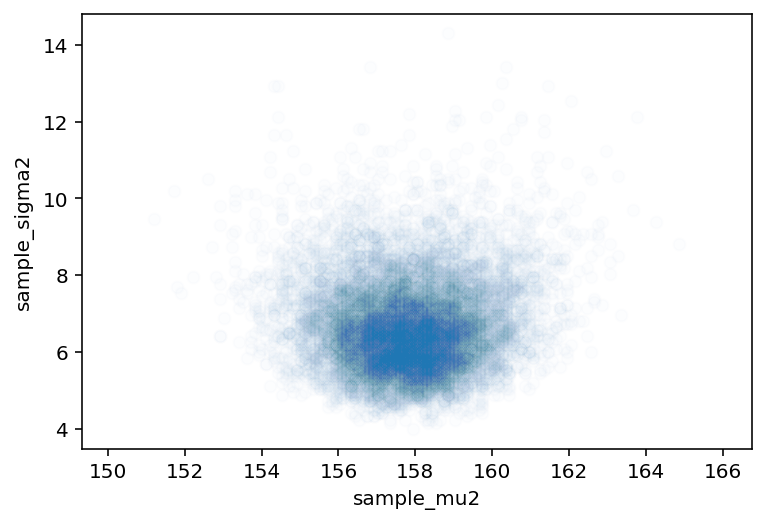

In [41]:
plt.plot(sample_mu, sample_sigma, "o", alpha=0.01)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2")
plt.grid(False);

### Code 4.25

<AxesSubplot:>

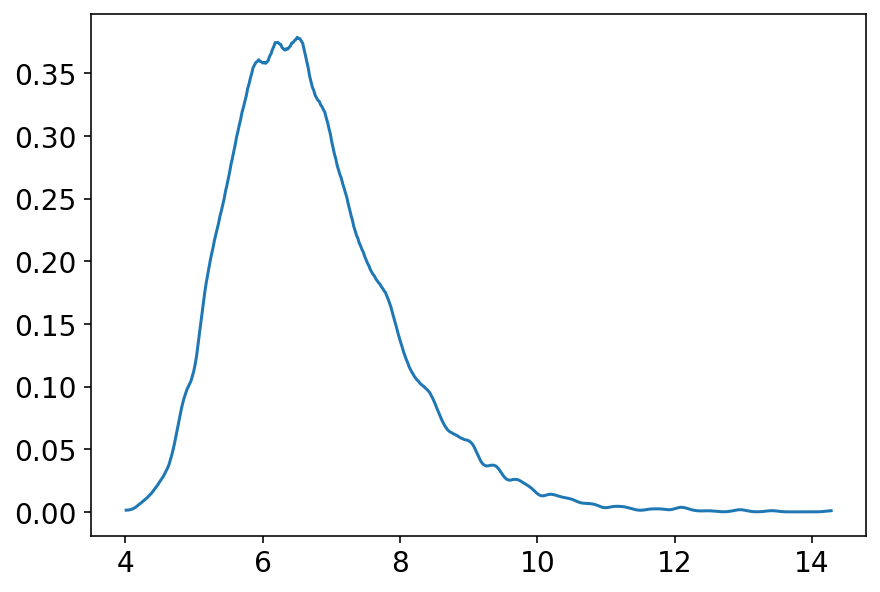

In [42]:
az.plot_kde(sample_sigma)

### Code 4.26

In [43]:
d = pd.read_csv("../../data/Howell1.csv", sep=';')
d2 = d[d['age'] >= 18].reset_index(drop=True)

### Code 4.27

In [44]:
with pm.Model() as model_4_1:
    mu = pm.Normal('mu', mu=178, sigma=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'])

### Code 4.28

In [45]:
with model_4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

<ipython-input-45-b291dc73a7a5>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_1 = pm.sample(1000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


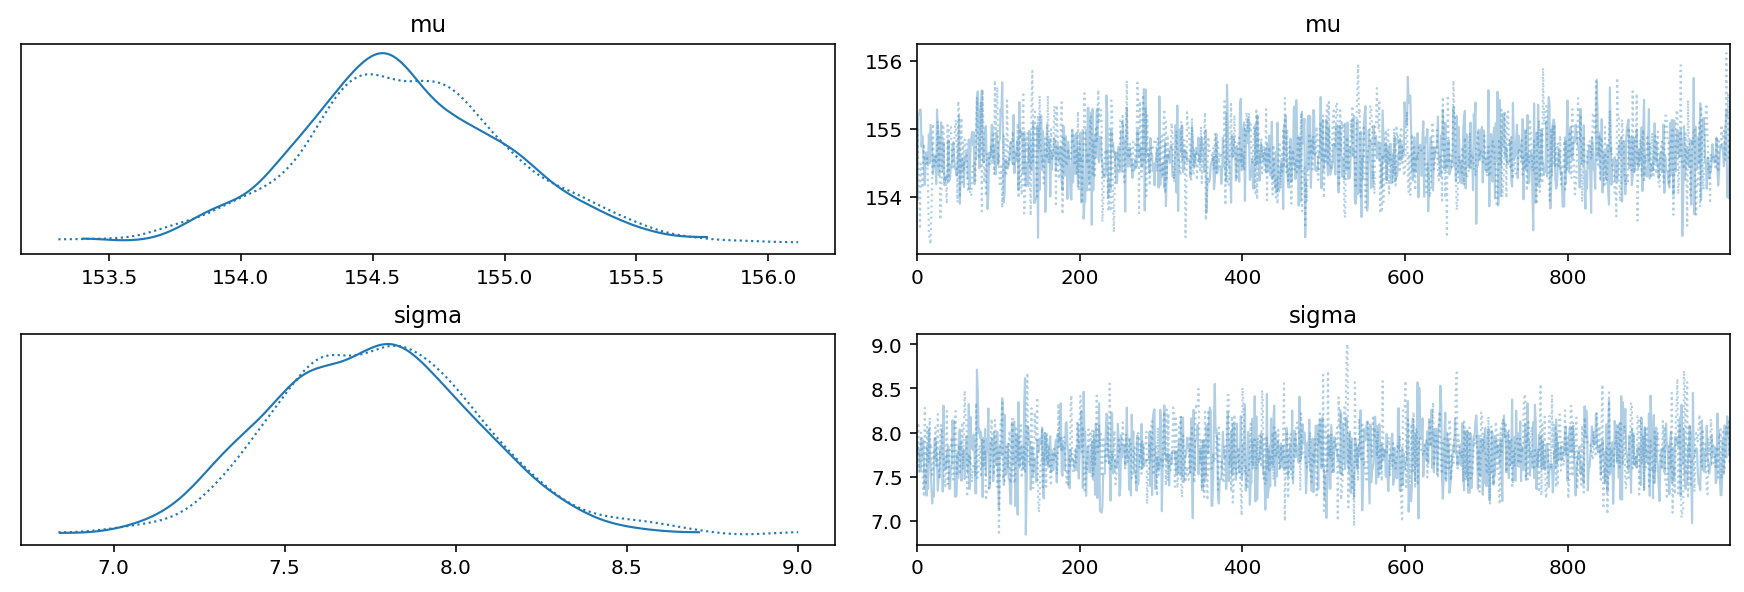

In [46]:
az.plot_trace(trace_4_1)
plt.show()

### Code 4.29

In [47]:
az.summary(trace_4_1, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     154.620  0.405   153.985    155.294      0.010    0.007    1684.0   
sigma    7.769  0.298     7.259      8.186      0.007    0.005    1825.0   

       ess_tail  r_hat  
mu       1460.0    1.0  
sigma    1465.0    1.0

### Code 4.30

In [48]:
with pm.Model() as model_4_1:
    mu = pm.Normal('mu', mu=178, sigma=20, testval=d2['height'].mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2['height'].std())
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'])
    trace_4_1 = pm.sample(10000, tune=1000)

<ipython-input-48-bc7435be20a2>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_1 = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 28 seconds.


In [49]:
az.summary(trace_4_1, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
mu     154.602  0.420   153.928    155.260      0.003    0.002   17346.0   
sigma    7.769  0.298     7.286      8.229      0.002    0.002   16930.0   

       ess_tail  r_hat  
mu      13861.0    1.0  
sigma   14458.0    1.0

### Code 4.31

In [50]:
with pm.Model() as model_4_2:
    mu = pm.Normal('mu', mu=178, sigma=0.1, testval=d2['height'].mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2['height'].std())
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'])
    trace_4_2 = pm.sample(10000, tune=1000)

<ipython-input-50-bf77437bdc72>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_2 = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 32 seconds.


In [51]:
az.summary(trace_4_2)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     177.864  0.102  177.673  178.053      0.001    0.001   17484.0   
sigma   24.612  0.942   22.835   26.361      0.007    0.005   17929.0   

       ess_tail  r_hat  
mu      13557.0    1.0  
sigma   12826.0    1.0

### Code 4.32

In [52]:
trace_4_1_df = pm.trace_to_dataframe(trace_4_1)
trace_4_1_df.cov()

mu     sigma
mu     0.176610 -0.001008
sigma -0.001008  0.088724

### Code 4.33

In [53]:
np.diag(trace_4_1_df.cov())

array([0.17661019, 0.08872417])

In [54]:
trace_4_1_df.corr()

mu     sigma
mu     1.000000 -0.008052
sigma -0.008052  1.000000

### Code 4.34

In [55]:
trace_4_1_df.head()

mu     sigma
0  154.732315  7.717609
1  154.555941  7.739942
2  154.534787  7.488981
3  154.870358  7.979745
4  154.870358  7.979745

### Code 4.35

In [56]:
trace_4_1_df.describe(percentiles=[.055, .945])

mu         sigma
count  20000.000000  20000.000000
mean     154.601811      7.769104
std        0.420250      0.297866
min      152.923763      6.669984
5.5%     153.934274      7.312537
50%      154.603682      7.759869
94.5%    155.269338      8.258678
max      156.344723      9.591974

In [57]:
az.summary(trace_4_1)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     154.602  0.420  153.785  155.354      0.003    0.002   17346.0   
sigma    7.769  0.298    7.224    8.330      0.002    0.002   16930.0   

       ess_tail  r_hat  
mu      13861.0    1.0  
sigma   14458.0    1.0

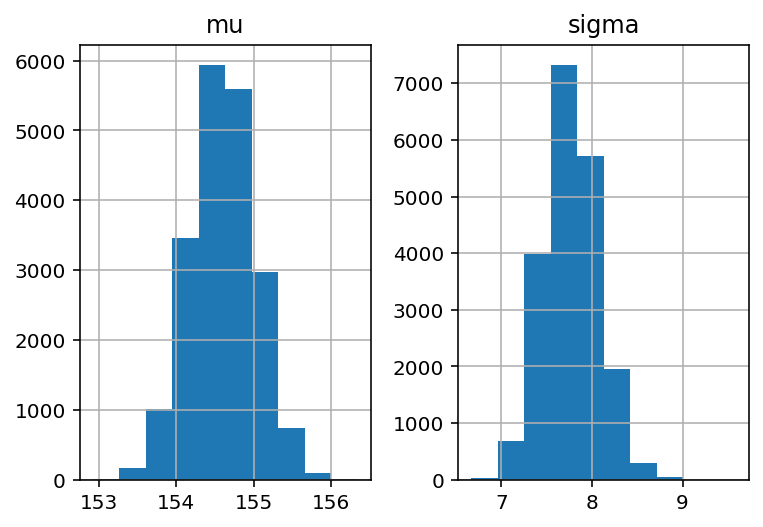

In [58]:
trace_4_1_df.hist()
plt.show()

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

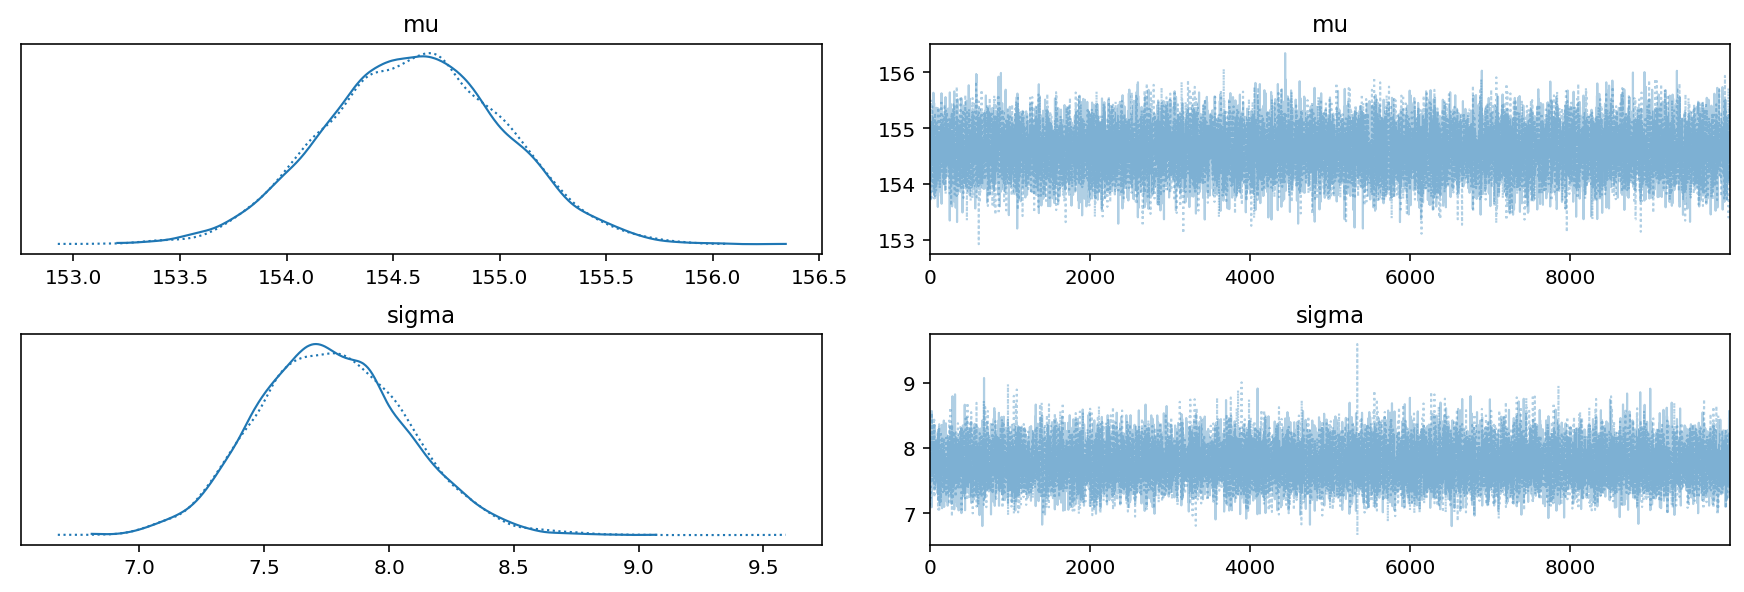

In [59]:
az.plot_trace(trace_4_1)

### Code 4.36

In [60]:
post = stats.multivariate_normal.rvs(mean=trace_4_1_df.mean(), cov=trace_4_1_df.cov(), size=10000)
post[:5, :]

array([[154.27765602,   8.05442022],
       [153.76987677,   8.00778739],
       [154.851677  ,   8.38306911],
       [155.13701765,   7.68725658],
       [155.46057021,   8.09913825]])

### Code 4.37

<AxesSubplot:xlabel='weight', ylabel='height'>

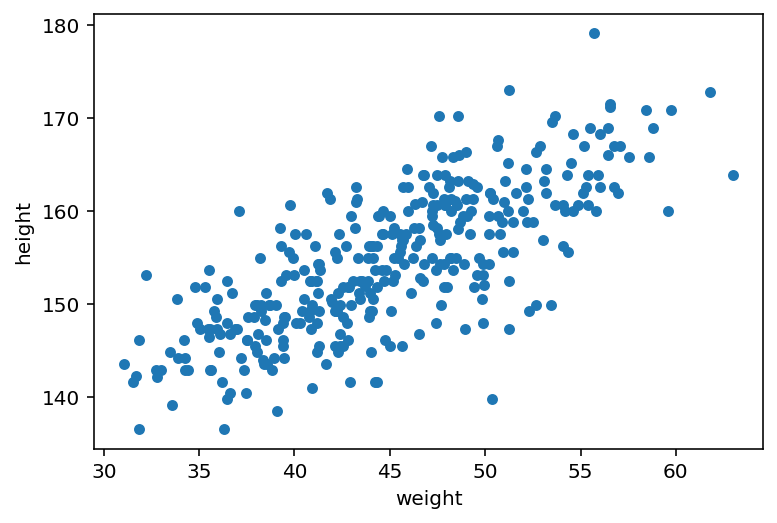

In [61]:
d2.plot('weight', 'height', kind='scatter')

### Code 4.38

In [62]:
np.random.seed(2971)
N = 100

a = stats.norm(178, 20).rvs(N)
b = stats.norm(0, 10).rvs(N)

### Code 4.39-4.41

In [63]:
x = np.linspace(d2['weight'].min(), d2['weight'].max(), 100)


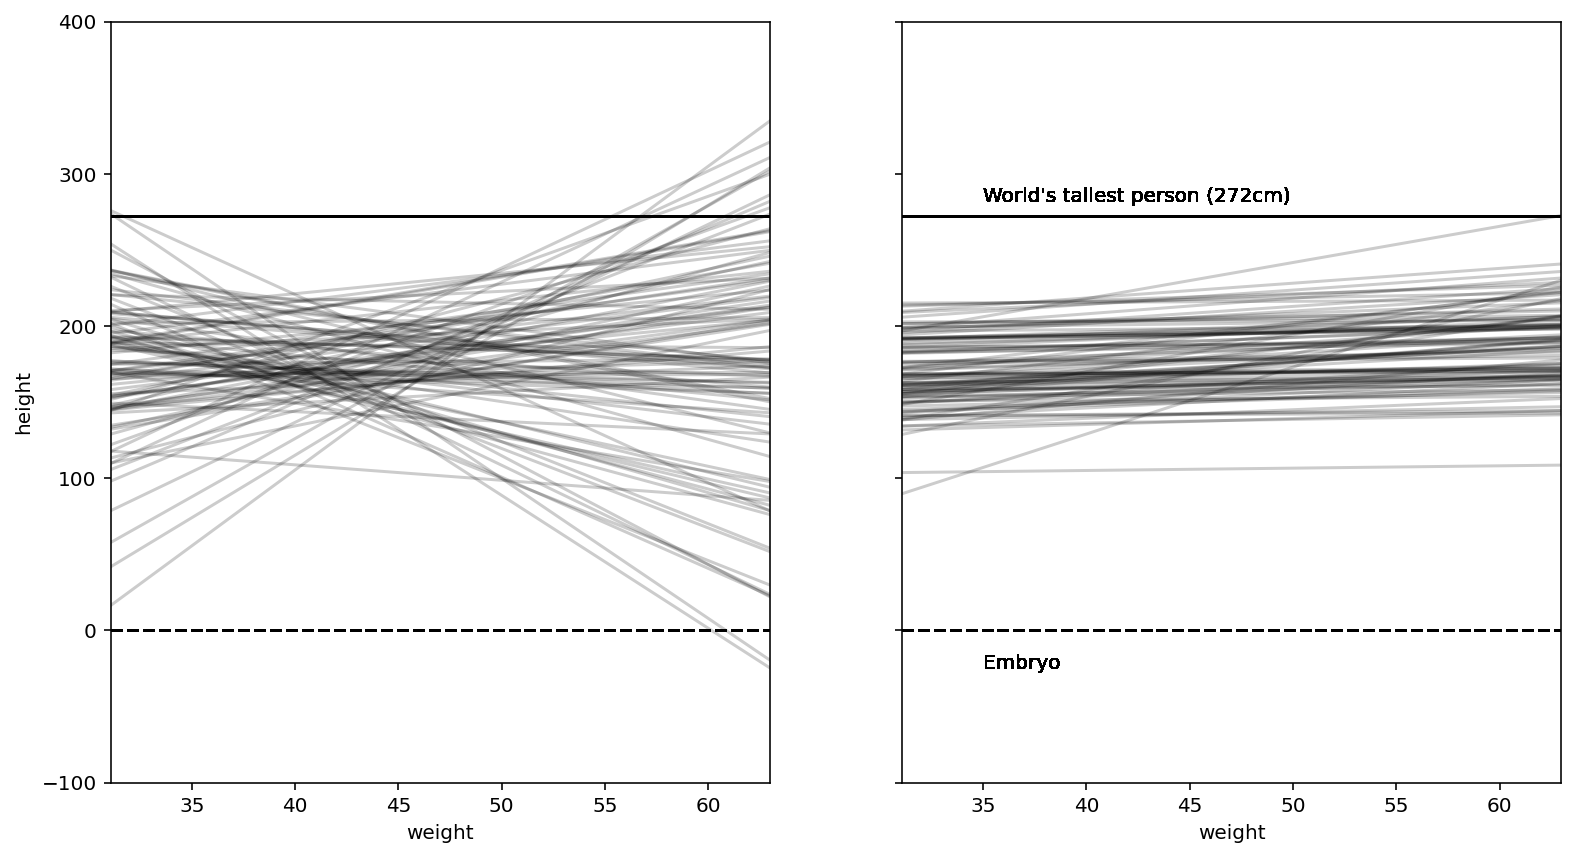

In [64]:
_, ax = plt.subplots(1, 2, sharey=True, figsize=(13, 7))
xbar = d2.weight.mean()
for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")

b = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo")
    
plt.show()

### Code 4.42

In [65]:
# load data again, since it's a long way back
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d2 = d[d['age'] >= 18].reset_index(drop=True)

# define the average weight, x-bar
xbar = d2['weight'].mean()

# fit model
with pm.Model() as model_4_3:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.Lognormal('b', mu=0, sigma=1)
    
    mu = a + b * (d2['weight'] - xbar)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'])
    
    trace_4_3 = pm.sample(10000, tune=1000)

<ipython-input-65-18ecf0fc1e5d>:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_3 = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 35 seconds.


### Code 4.43

In [66]:
with pm.Model() as model_4_3b:
    a = pm.Normal('a', mu=178, sigma=20)
    log_b = pm.Normal('b', mu=0, sigma=1)
    
    mu = a + np.exp(log_b) * (d2['weight'] - xbar)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2['height'])
    
    trace_4_3b = pm.sample(10000, tune=1000)    

<ipython-input-66-b5846b641ddb>:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_3b = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.


### Code 4.44

In [67]:
az.summary(trace_4_3, var_names=['a', 'b', 'sigma'], hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_5.5%  hdi_94.5%
a      154.602  0.274   154.153    155.020
b        0.903  0.042     0.836      0.970
sigma    5.104  0.198     4.783      5.408

### Code 4.45

In [68]:
pm.trace_to_dataframe(trace_4_3).cov().round(3)

a      b  sigma
a      0.075  0.000  0.001
b      0.000  0.002 -0.000
sigma  0.001 -0.000  0.039

### Code 4.46

In [69]:
xgrid = np.linspace(d2['weight'].min(), d2['weight'].max(), 100)
line = trace_4_3['a'].mean() + trace_4_3['b'].mean() * (xgrid - xbar)

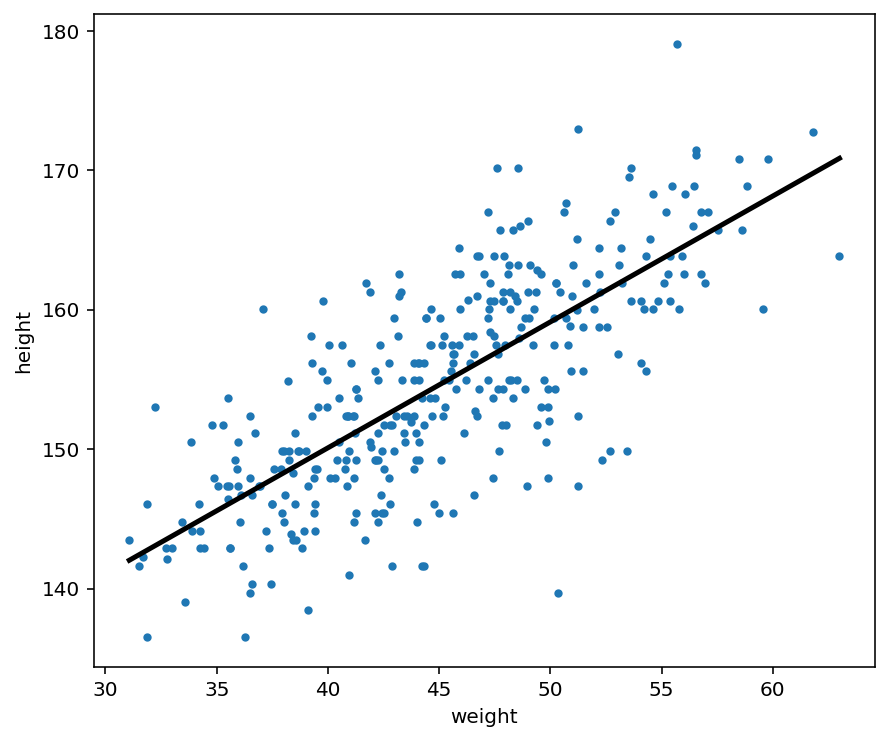

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(d2['weight'], d2['height'], s=10)
ax.plot(xgrid, line, color='black', linewidth=2.5)
ax.set_xlabel('weight')
ax.set_ylabel('height')

plt.show()

### Code 4.47

In [71]:
dN = d2.head(10)

### Code 4.48

In [72]:
# fit model
with pm.Model() as model_N:
    a = pm.Normal('a', mu=178, sigma=20)
    b = pm.Lognormal('b', mu=0, sigma=1)
    
    mu = a + b * (dN['weight'] - dN['weight'].mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=dN['height'])
    
    trace_N = pm.sample(10000, tune=1000)

<ipython-input-72-4a9dc1f4a1f0>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_N = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.


In [73]:
trace_N_df = pm.trace_to_dataframe(trace_N)

### Code 4.49

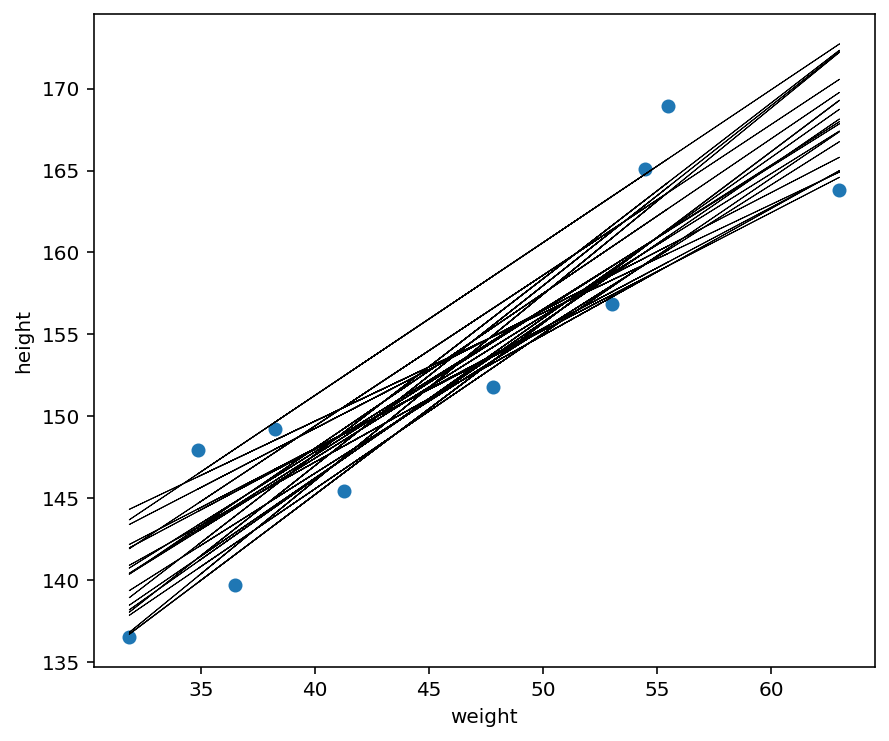

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(dN['weight'], dN['height'])
for _, row in trace_N_df.head(20).iterrows():
    ax.plot(dN['weight'],
            row['a'] + row['b'] * (dN['weight'] - dN['weight'].mean()),
            c='black', linewidth=.5)
    
ax.set_ylabel('height')
ax.set_xlabel('weight')
plt.show()

<ipython-input-75-f432bd04b038>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_N = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 42 seconds.
<ipython-input-75-f432bd04b038>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_N = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 33 seconds.
<ipython-input-75-f432bd04b038>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_N = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
<ipython-input-75-f432bd04b038>:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_N = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.


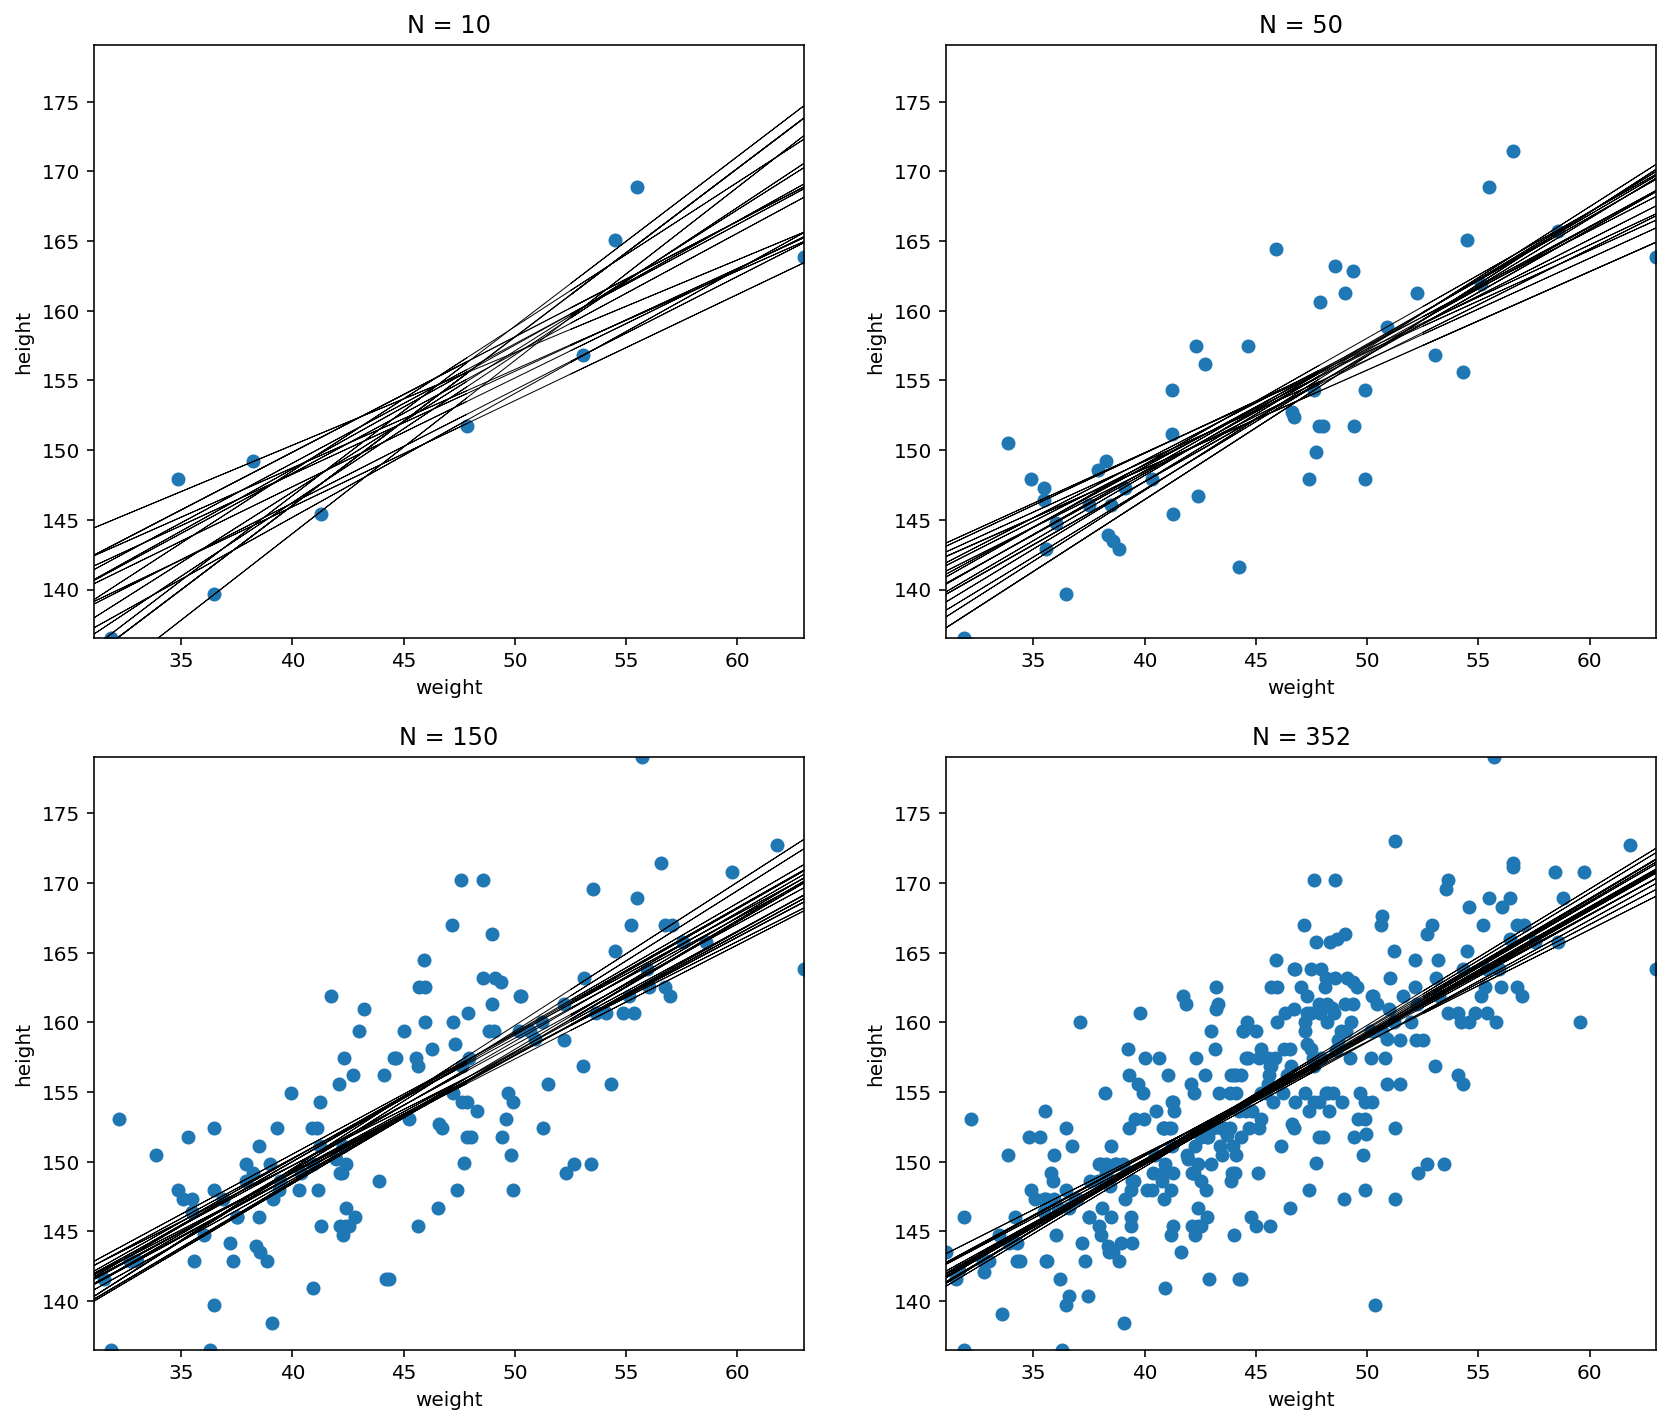

In [75]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()
Ns = [10, 50, 150, 352]

for i in range(4):
    N = Ns[i]
    dN = d2.head(N)
    with pm.Model() as model_N:
        a = pm.Normal('a', mu=178, sigma=20)
        b = pm.Lognormal('b', mu=0, sigma=1)

        mu = a + b * (dN['weight'] - dN['weight'].mean())
        sigma = pm.Uniform('sigma', lower=0, upper=50)

        height = pm.Normal('height', mu=mu, sigma=sigma, observed=dN['height'])

        trace_N = pm.sample(10000, tune=1000)
    trace_N_df = pm.trace_to_dataframe(trace_N)
    for _, row in trace_N_df.head(20).iterrows():
        axes[i].plot(d2['weight'],
                     row['a'] + row['b'] * (d2['weight'] - dN['weight'].mean()),
                     c='black', linewidth=.5)
    
    axes[i].scatter(dN['weight'], dN['height'])
    
    axes[i].set_ylabel('height')
    axes[i].set_xlabel('weight')
    axes[i].set_ylim(d2['height'].min(), d2['height'].max())
    axes[i].set_xlim(d2['weight'].min(), d2['weight'].max())
    axes[i].set_title(f'N = {N}')
    
plt.show()

### Code 4.50

In [76]:
mu_at_50 = trace_4_3['a'] + trace_4_3['b'] * (50 - d2['weight'].mean())

### Code 4.51

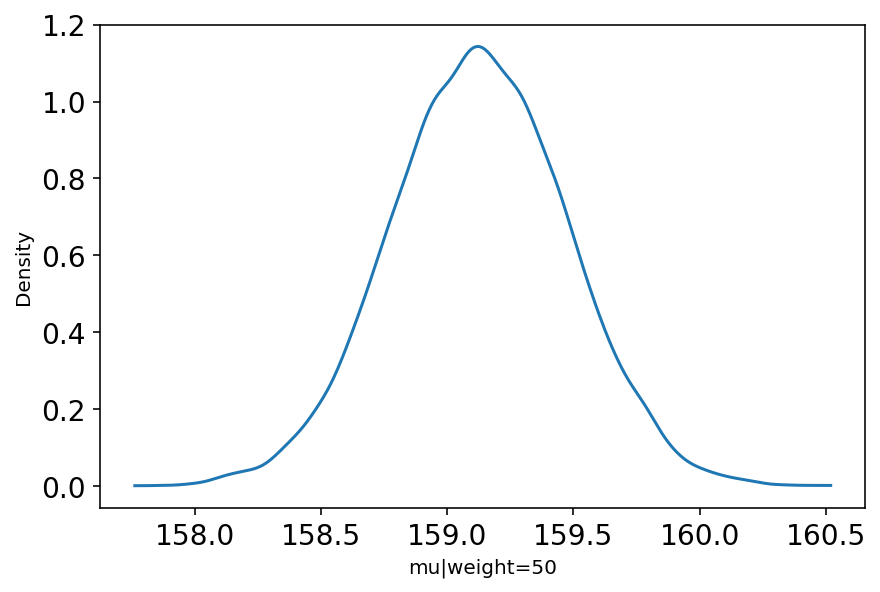

In [77]:
ax = az.plot_kde(mu_at_50)
ax.set_ylabel('Density')
ax.set_xlabel('mu|weight=50')
plt.show()

### Code 4.52

In [78]:
az.hdi(mu_at_50, hdi_prob=.89)

array([158.58273766, 159.69310267])

### Code 4.53

In [79]:
mu = []
xbar = d2['weight'].mean()
for w in d2['weight'].values:
    mu.append(trace_4_3['a'] + trace_4_3['b'] * (w - xbar))
    
mu = np.array(mu).T

### Code 4.54

In [80]:
weight_grid = np.arange(25, 70)

In [81]:
mu = []
xbar = d2['weight'].mean()
for w in weight_grid:
    mu.append(trace_4_3['a'] + trace_4_3['b'] * (w - xbar))
    
mu = np.array(mu).T

In [82]:
mu

array([[136.87669182, 137.77290074, 138.66910966, ..., 174.51746637,
        175.41367529, 176.30988421],
       [135.6109987 , 136.5720307 , 137.53306269, ..., 175.9743425 ,
        176.9353745 , 177.89640649],
       [137.33457939, 138.1805954 , 139.0266114 , ..., 172.86725168,
        173.71326769, 174.55928369],
       ...,
       [136.50004264, 137.3638587 , 138.22767476, ..., 172.78031722,
        173.64413328, 174.50794934],
       [137.23282806, 138.08243884, 138.93204963, ..., 172.91648093,
        173.76609171, 174.61570249],
       [136.20346733, 137.13106799, 138.05866864, ..., 175.16269494,
        176.0902956 , 177.01789626]])

### Code 4.55

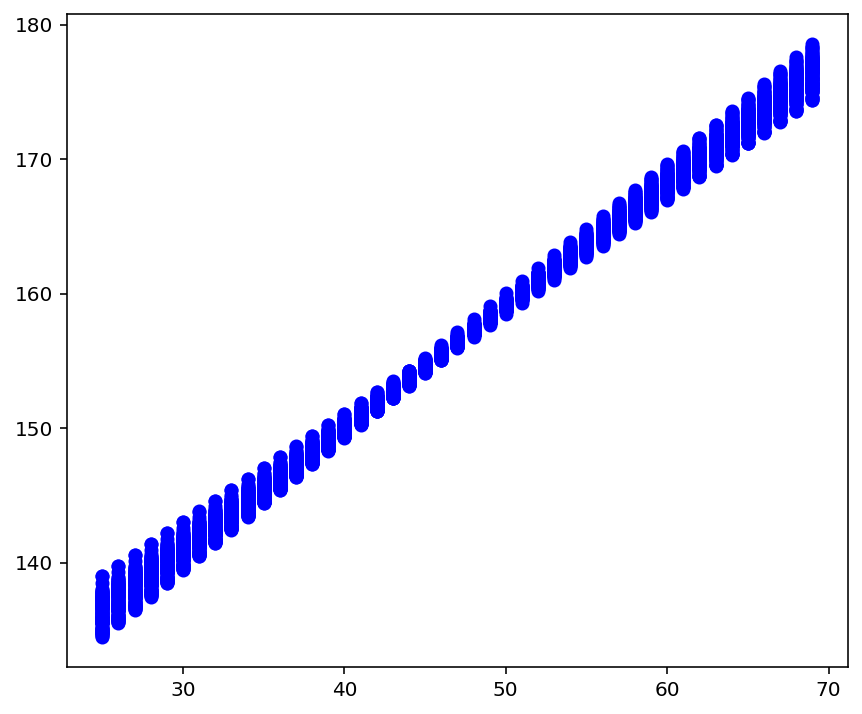

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
for i in range(100):
    ax.scatter(weight_grid, mu[i, :], color='blue')
plt.show()

In [84]:
mu.shape

(20000, 45)

### Code 4.56

In [85]:
mu_mean = mu.mean(axis=0)
mu_pi = np.array([az.hdi(mu[:, i], hdi_prob=.89) for i in range(mu.shape[1])])

### Code 4.57

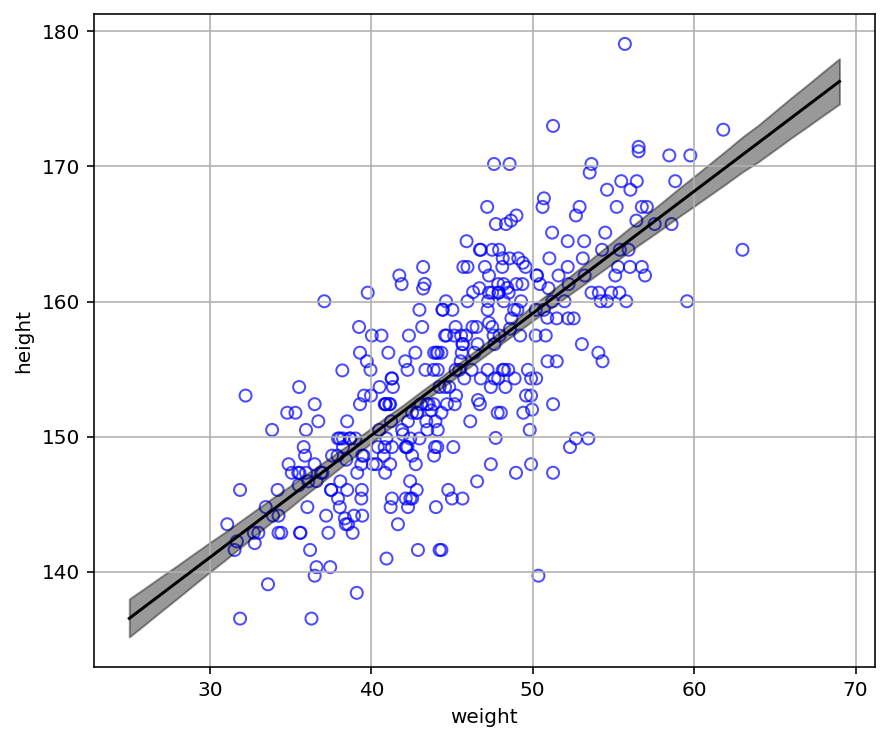

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(d2['weight'], d2['height'], marker='o', facecolors='none', edgecolors='blue', alpha=.7)
ax.plot(weight_grid, mu_mean, c='black')
ax.fill_between(weight_grid, mu_pi[:, 0], mu_pi[:, 1], color='black', alpha=.4)
ax.set_xlabel('weight')
ax.set_ylabel('height')
ax.grid()
plt.show()

### Code 4.59

In [87]:
sim_height = []
for w in weight_grid:
    mu = trace_4_3['a'] + trace_4_3['b'] * (w - xbar)
    sh = stats.norm(loc=mu, scale=trace_4_3['sigma']).rvs()
    sim_height.append(sh)
sim_height = np.array(sim_height).T

### Code 4.60

In [88]:
height_pi_67 = az.hdi(sim_height, hdi_prob=.67)
height_pi_89 = az.hdi(sim_height, hdi_prob=.89)
height_pi_97 = az.hdi(sim_height, hdi_prob=.97)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


### Code 4.61

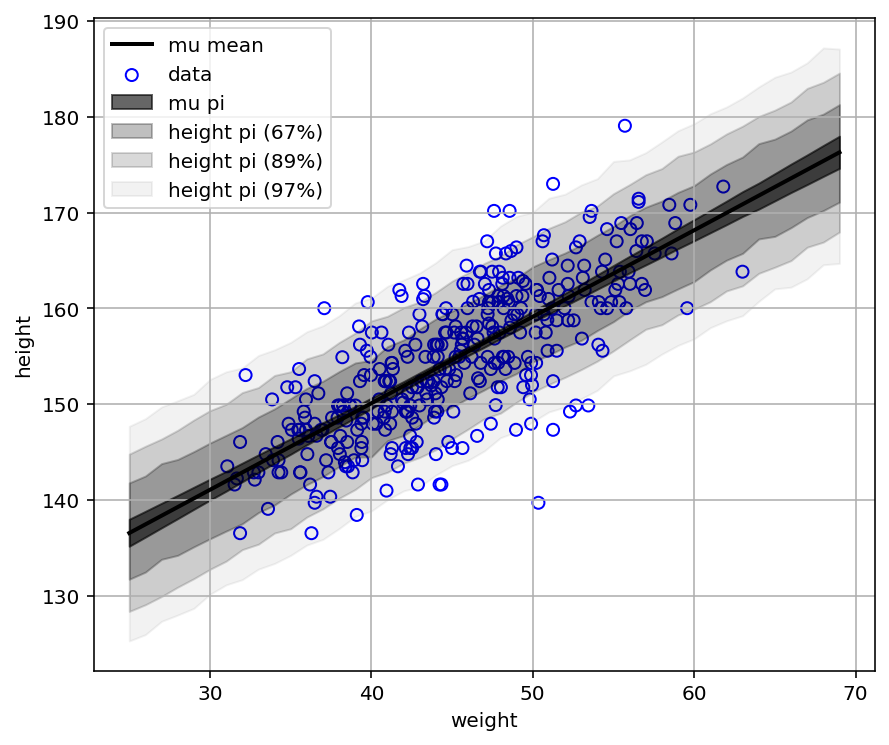

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
ax.scatter(d2['weight'], d2['height'], facecolors='none', edgecolors='blue', label='data')
ax.plot(weight_grid, mu_mean, color='black', linewidth=2, label='mu mean')
ax.fill_between(weight_grid, mu_pi[:, 0], mu_pi[:, 1], color='black', alpha=.6, label='mu pi')
ax.fill_between(weight_grid, height_pi_67[:, 0], height_pi_67[:, 1], color='black', alpha=.25, label='height pi (67%)')
ax.fill_between(weight_grid, height_pi_89[:, 0], height_pi_89[:, 1], color='black', alpha=.15, label='height pi (89%)')
ax.fill_between(weight_grid, height_pi_97[:, 0], height_pi_97[:, 1], color='black', alpha=.05, label='height pi (97%)')
ax.set_xlabel('weight')
ax.set_ylabel('height')
ax.grid()
ax.legend()
plt.show()

### Code 4.64

In [90]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

<AxesSubplot:xlabel='weight', ylabel='height'>

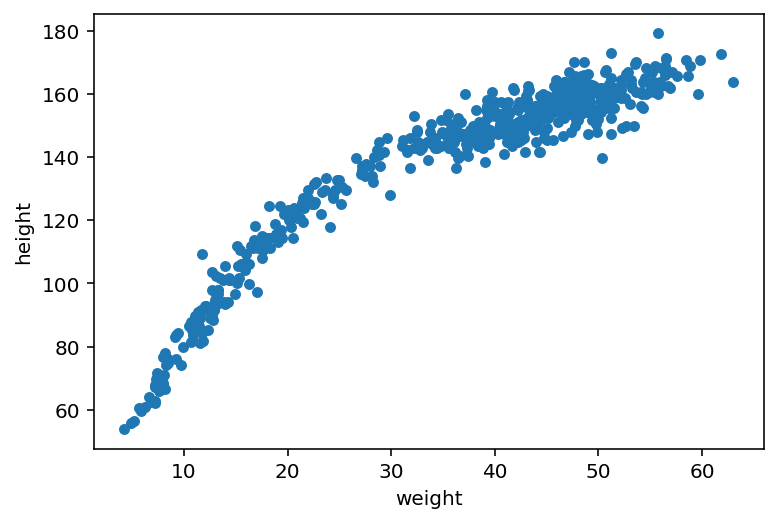

In [91]:
d.plot('weight', 'height', kind='scatter')

### Code 4.65

In [92]:
d['weight_s'] = (d['weight'] - d['weight'].mean()) / d['weight'].std()
d['weight_s2'] = d['weight_s'] ** 2

In [93]:
with pm.Model() as model_4_5:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    a = pm.Normal('a', mu=178, sigma=20)
    b1 = pm.Lognormal('b1', mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    
    mu = a + b1*d['weight_s'] + b2*d['weight_s2']
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d['height'])
    
    trace_4_5 = pm.sample(10000, tune=1000)

<ipython-input-93-90b8cbdbd82a>:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_5 = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b2, b1, a, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 39 seconds.


In [94]:
az.summary(trace_4_5, hdi_prob=.89, kind='stats').sort_index()

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_5.5%  hdi_94.5%
a      146.050  0.378   145.435    146.638
b1      21.738  0.296    21.268     22.206
b2      -7.796  0.282    -8.233     -7.332
sigma    5.805  0.180     5.512      6.080

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


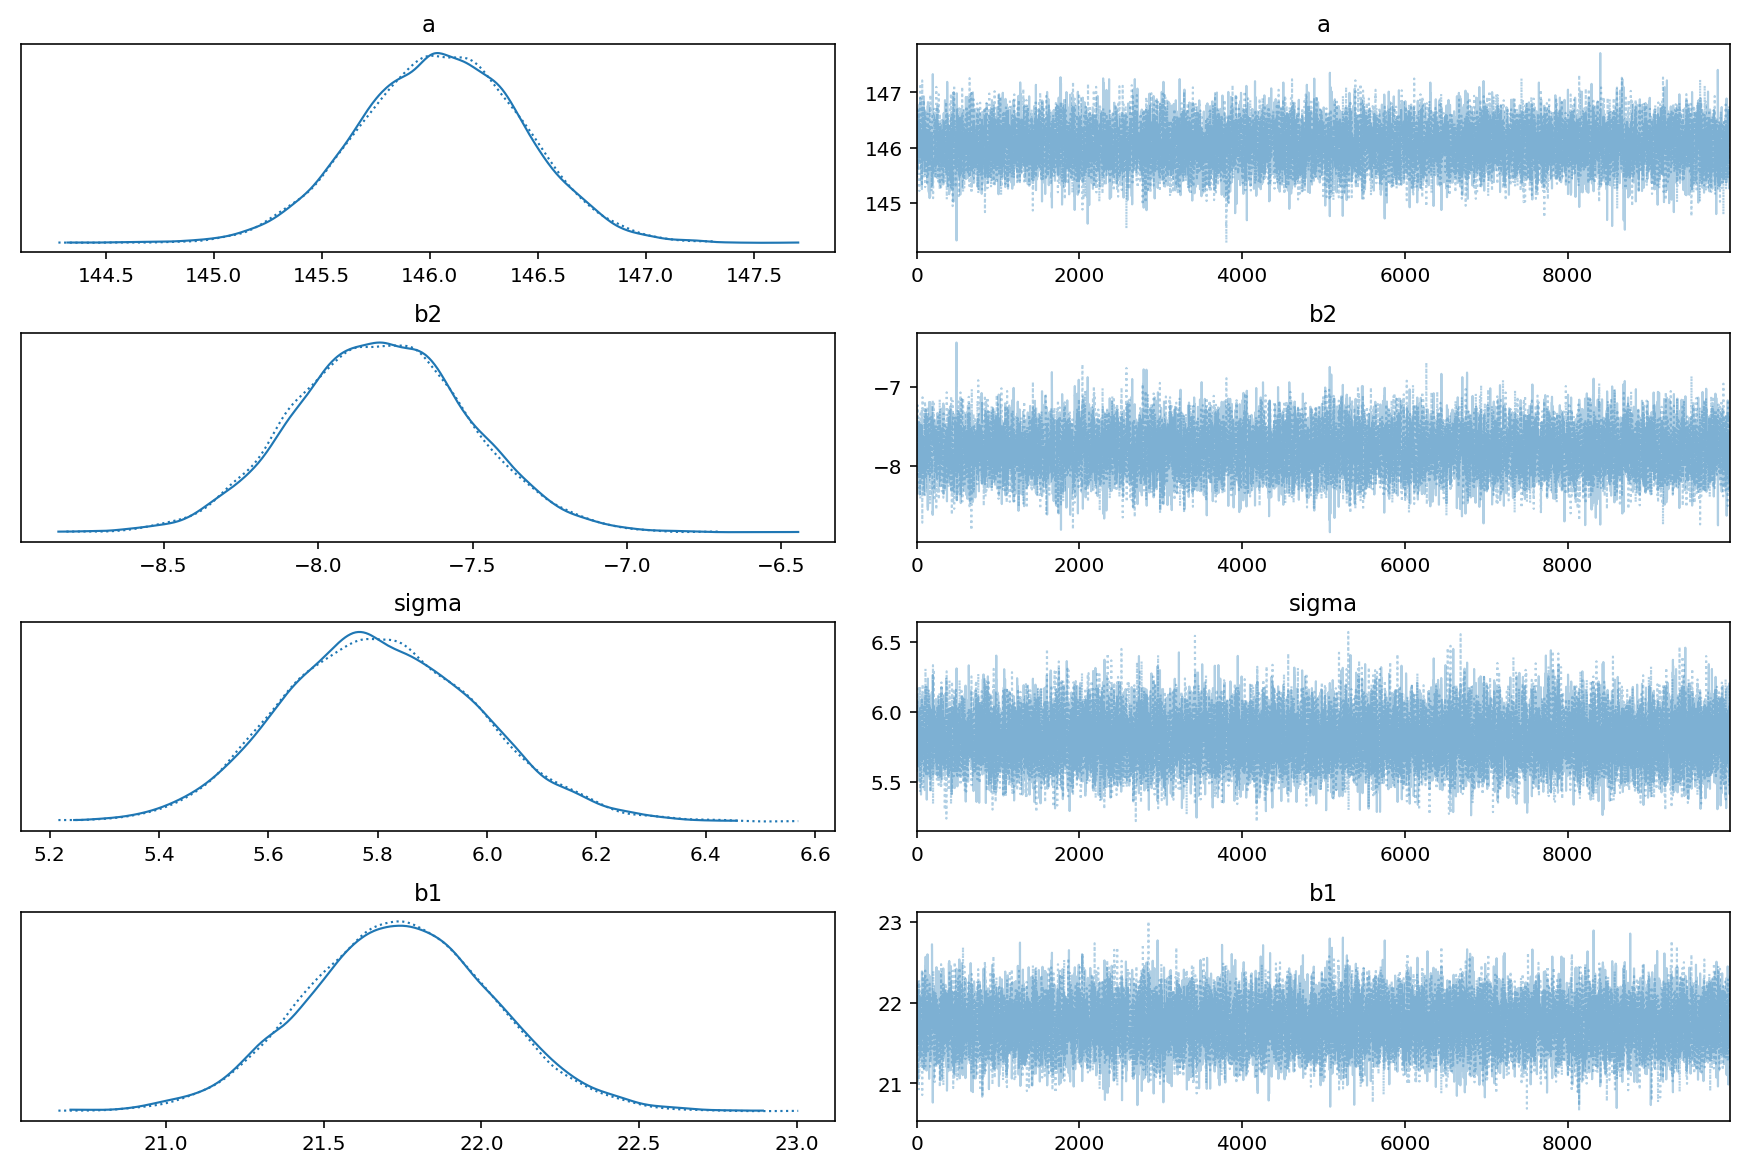

In [95]:
az.plot_trace(trace_4_5)
plt.show()

### Code 4.67

In [96]:
weight_grid = np.linspace(d['weight_s'].min(), d['weight_s'].max(), 30)
pred_dat = pd.DataFrame({'weight_s': weight_grid, 'weight_s2': weight_grid**2})

In [97]:
mu = []
sim_height = []
for _, row in pred_dat.iterrows():
    mu_point = trace_4_5['a'] + trace_4_5['b1']*row['weight_s'] + trace_4_5['b2']*row['weight_s2']
    height_point = stats.norm(mu_point, trace_4_5['sigma']).rvs()
    mu.append(mu_point)
    sim_height.append(height_point)
    
mu = np.array(mu).T
sim_height = np.array(sim_height).T

In [98]:
mu_mean = mu.mean(axis=0)
mu_pi = az.hdi(mu, hdi_prob=.89)
height_pi = az.hdi(sim_height, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


### Code 4.68

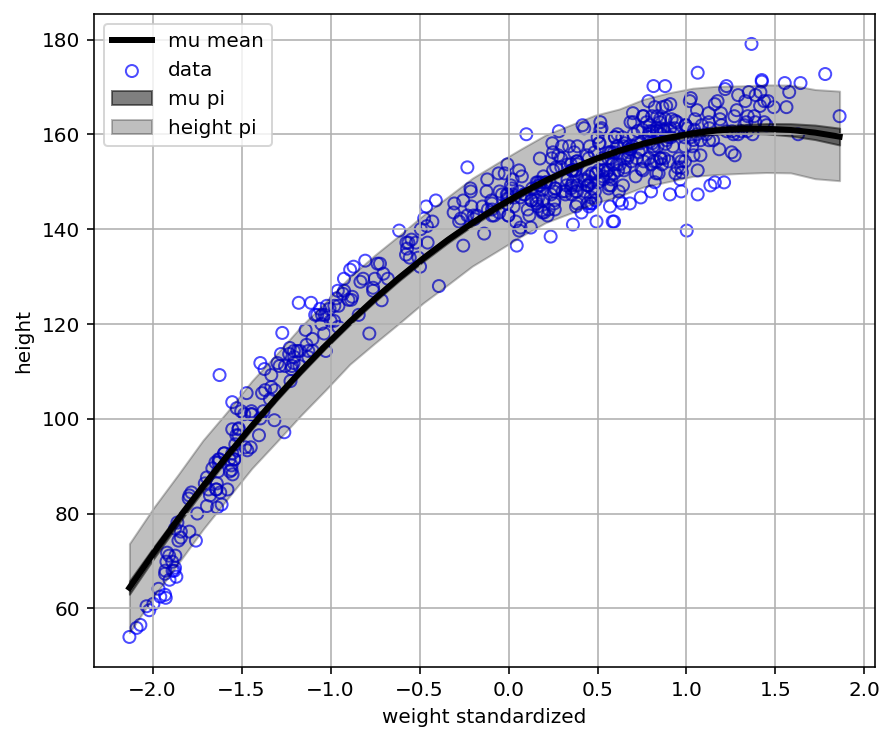

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(d['weight_s'], d['height'], marker='o', facecolors='none', edgecolors='blue', label='data', alpha=.7)
ax.plot(weight_grid, mu_mean, color='black', linewidth=3, label='mu mean')
ax.fill_between(weight_grid, mu_pi[:, 0], mu_pi[:, 1], color='black', alpha=.5, label='mu pi')
ax.fill_between(weight_grid, height_pi[:, 0], height_pi[:, 1], color='black', alpha=.25, label='height pi')
ax.grid()
ax.legend()
ax.set_xlabel('weight standardized')
ax.set_ylabel('height')

plt.show()

### Code 4.71

In [100]:
d['weight_s3'] = d['weight_s'] ** 3

In [101]:
with pm.Model() as model_4_6:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    
    a = pm.Normal('a', mu=178, sigma=20)
    b1 = pm.Lognormal('b1', mu=0, sigma=1)
    b2 = pm.Normal('b2', mu=0, sigma=1)
    b3 = pm.Normal('b3', mu=0, sigma=1)
    
    mu = a + b1*d['weight_s'] + b2*d['weight_s2'] + b3*d['weight_s3']
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d['height'])
    
    trace_4_6 = pm.sample(10000, tune=1000)    

<ipython-input-101-3b3c3b76defb>:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_6 = pm.sample(10000, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b3, b2, b1, a, sigma]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 49 seconds.


In [102]:
weight_grid = np.linspace(d['weight_s'].min(), d['weight_s'].max(), 30)
pred_dat = pd.DataFrame({'weight_s': weight_grid,
                         'weight_s2': weight_grid**2,
                         'weight_s3': weight_grid**3})

In [103]:
mu = []
sim_height = []
for _, row in pred_dat.iterrows():
    mu_point = trace_4_6['a'] + \
        trace_4_6['b1']*row['weight_s'] + \
        trace_4_6['b2']*row['weight_s2'] + \
        trace_4_6['b3']*row['weight_s3']
    height_point = stats.norm(mu_point, trace_4_6['sigma']).rvs()
    mu.append(mu_point)
    sim_height.append(height_point)
    
mu = np.array(mu).T
sim_height = np.array(sim_height).T

In [104]:
mu_mean = mu.mean(axis=0)
mu_pi = az.hdi(mu, hdi_prob=.89)
height_pi = az.hdi(sim_height, hdi_prob=.89)

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


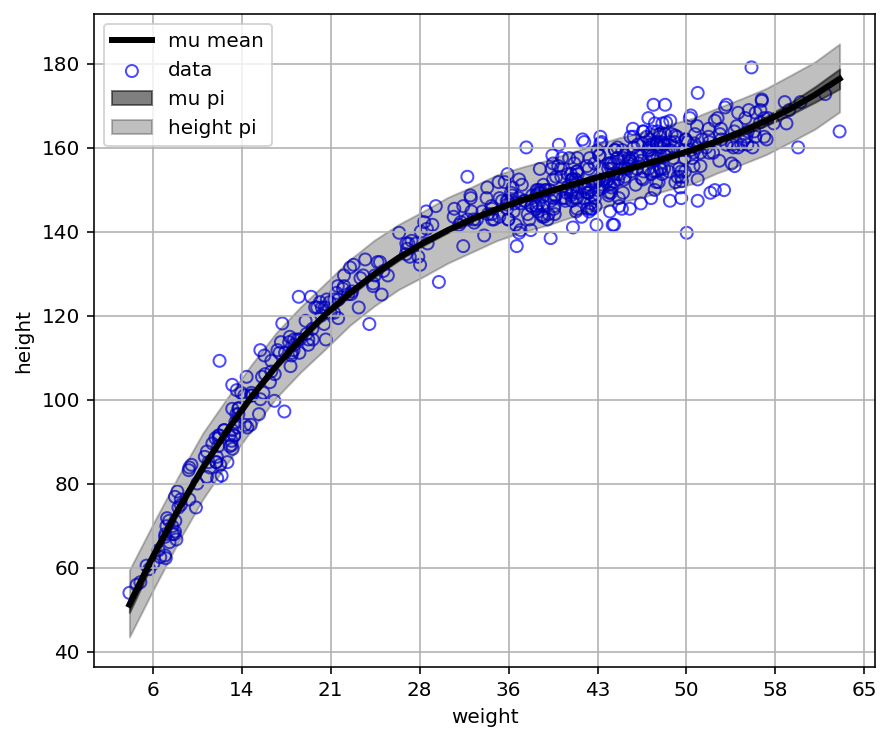

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.scatter(d['weight_s'], d['height'], marker='o', facecolors='none', edgecolors='blue', label='data', alpha=.7)
ax.plot(weight_grid, mu_mean, color='black', linewidth=3, label='mu mean')
ax.fill_between(weight_grid, mu_pi[:, 0], mu_pi[:, 1], color='black', alpha=.5, label='mu pi')
ax.fill_between(weight_grid, height_pi[:, 0], height_pi[:, 1], color='black', alpha=.25, label='height pi')
ax.grid()
ax.legend()
ax.set_xlabel('weight')
ax.set_ylabel('height')
ax.xaxis.set_major_formatter(lambda x, _: '{:.0f}'.format((x * d['weight'].std()) + d['weight'].mean()))

plt.show()

### Code 4.72

In [106]:
d = pd.read_csv('../../data/cherry_blossoms.csv')

In [107]:
d.head()

year  doy  temp  temp_upper  temp_lower
0   801  NaN   NaN         NaN         NaN
1   802  NaN   NaN         NaN         NaN
2   803  NaN   NaN         NaN         NaN
3   804  NaN   NaN         NaN         NaN
4   805  NaN   NaN         NaN         NaN

In [108]:
d.describe()

year         doy         temp   temp_upper   temp_lower
count  1215.000000  827.000000  1124.000000  1124.000000  1124.000000
mean   1408.000000  104.540508     6.141886     7.185151     5.098941
std     350.884596    6.407036     0.663648     0.992921     0.850350
min     801.000000   86.000000     4.670000     5.450000     0.750000
25%    1104.500000  100.000000     5.700000     6.480000     4.610000
50%    1408.000000  105.000000     6.100000     7.040000     5.145000
75%    1711.500000  109.000000     6.530000     7.720000     5.542500
max    2015.000000  124.000000     8.300000    12.100000     7.740000

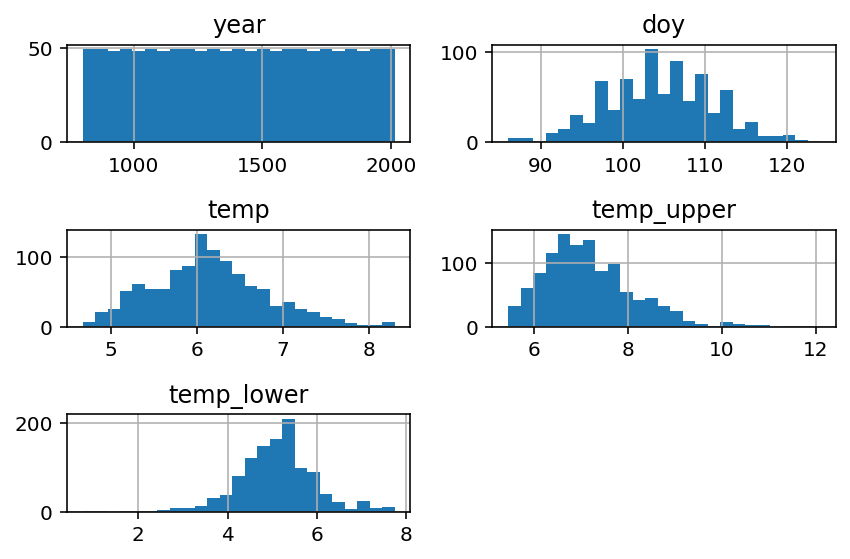

In [109]:
d.hist(bins=25)
plt.tight_layout()
plt.show()

### Code 4.73

In [110]:
d2 = d[d['doy'].notna()].reset_index(drop=True)
num_knots = 15
knot_list = np.quantile(d2['year'], q=np.linspace(0, 1, num_knots))

In [111]:
knot_list

array([ 812., 1036., 1174., 1269., 1377., 1454., 1518., 1583., 1650.,
       1714., 1774., 1833., 1893., 1956., 2015.])

### Code 4.74

In [112]:
B = bs(d2['year'], knots=knot_list[1:-1], degree=3, include_intercept=True).values

In [113]:
B.shape

(827, 17)

### Code 4.75

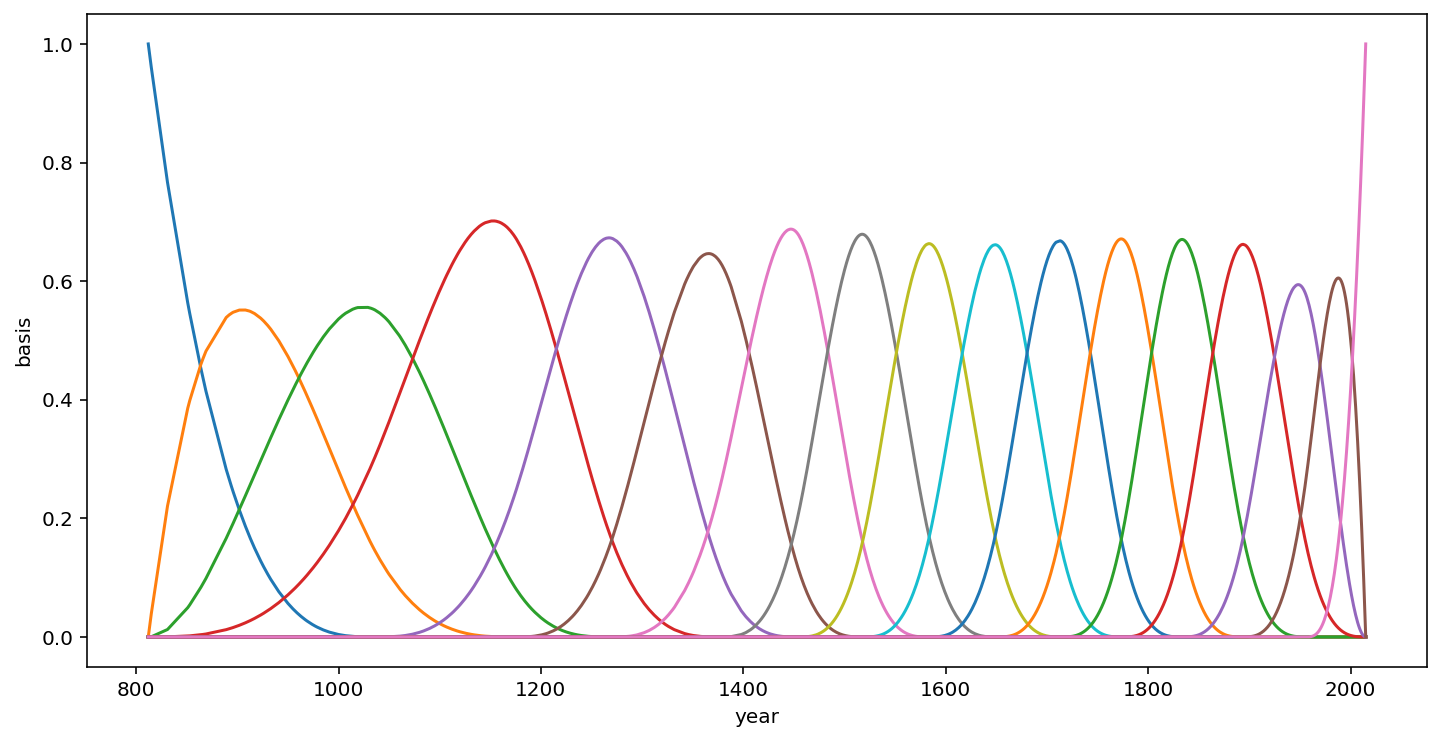

In [114]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for i in range(B.shape[1]):
    ax.plot(d2.year, (B[:, i]))
ax.set_xlabel("year")
ax.set_ylabel("basis");

plt.show()

### Code 4.76

In [115]:
with pm.Model() as model_4_7:
    a = pm.Normal('a', mu=100, sigma=10)
    sigma = pm.Exponential('sigma', lam=1)
    w = pm.Normal('w', mu=0, sigma=10, shape=B.shape[1])
    mu = pm.Deterministic('mu', a + pm.math.dot(B, w.T))
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=d2['doy'])
    trace_4_7 = pm.sample(5000, tune=10000)

<ipython-input-115-a6a6d8e60d1f>:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_4_7 = pm.sample(5000, tune=10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, sigma, a]


Sampling 2 chains for 10_000 tune and 5_000 draw iterations (20_000 + 10_000 draws total) took 151 seconds.
There were 2559 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6071817868497419, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [116]:
az.summary(trace_4_7, var_names=['a', 'sigma'], hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_5.5%  hdi_94.5%
a      103.108  2.302    99.141    106.448
sigma    5.947  0.143     5.709      6.167

In [117]:
az.summary(trace_4_7, var_names=['w'], hdi_prob=.89, kind='stats')

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_5.5%  hdi_94.5%
w[0]  -2.774  3.731    -8.573      3.339
w[1]  -0.662  3.821    -6.427      5.702
w[2]  -0.748  3.498    -6.167      5.149
w[3]   5.090  2.837     0.599      9.495
w[4]  -0.651  2.818    -5.064      3.902
w[5]   4.614  2.881    -0.084      9.039
w[6]  -5.134  2.723    -9.136     -0.507
w[7]   8.111  2.817     3.772     12.742
w[8]  -0.782  2.808    -5.415      3.454
w[9]   3.262  2.908    -1.589      7.628
w[10]  4.854  2.827     0.212      9.208
w[11]  0.160  2.868    -4.842      4.436
w[12]  5.703  2.791     1.003      9.911
w[13]  1.073  3.007    -3.670      5.895
w[14] -0.690  3.256    -5.882      4.467
w[15] -6.588  3.379   -11.964     -1.329
w[16] -7.479  3.216   -12.769     -2.508

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

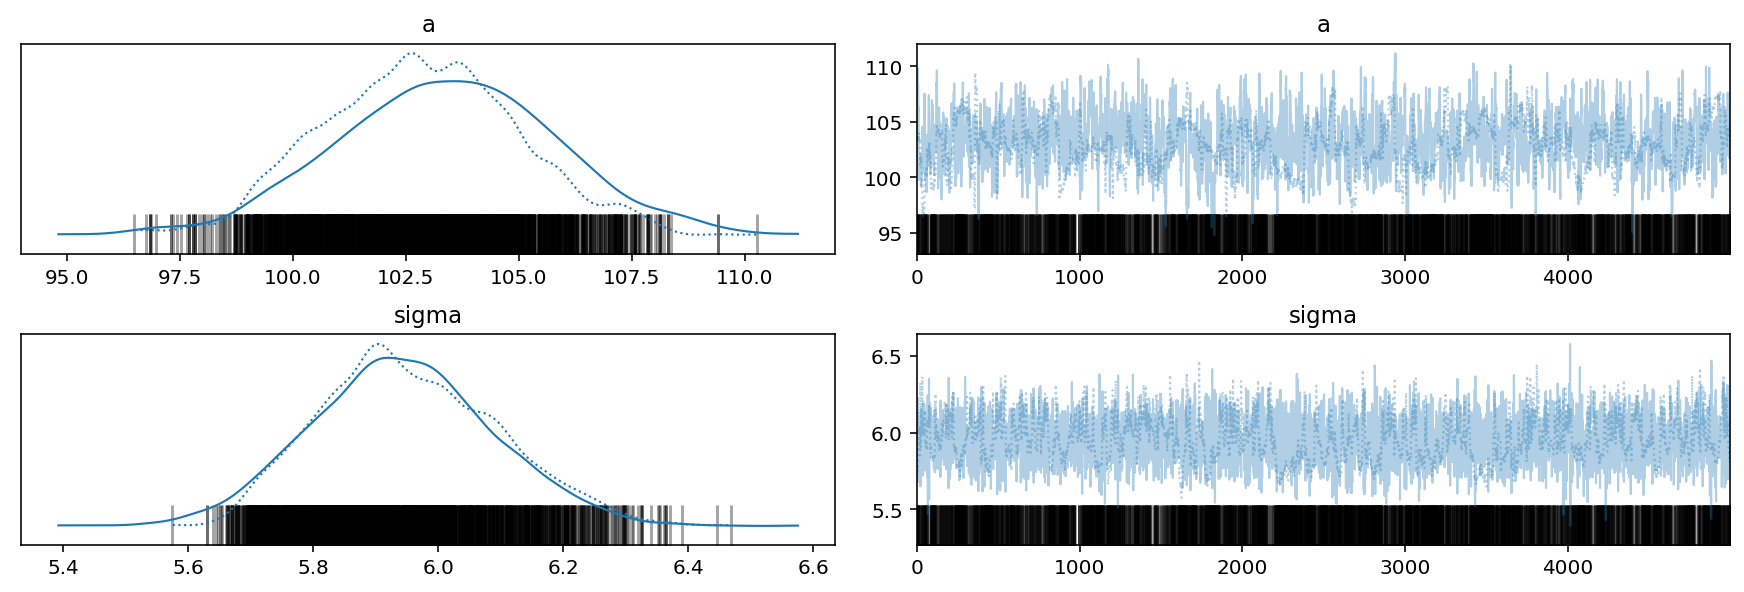

In [118]:
az.plot_trace(trace_4_7, var_names=['a', 'sigma'])

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


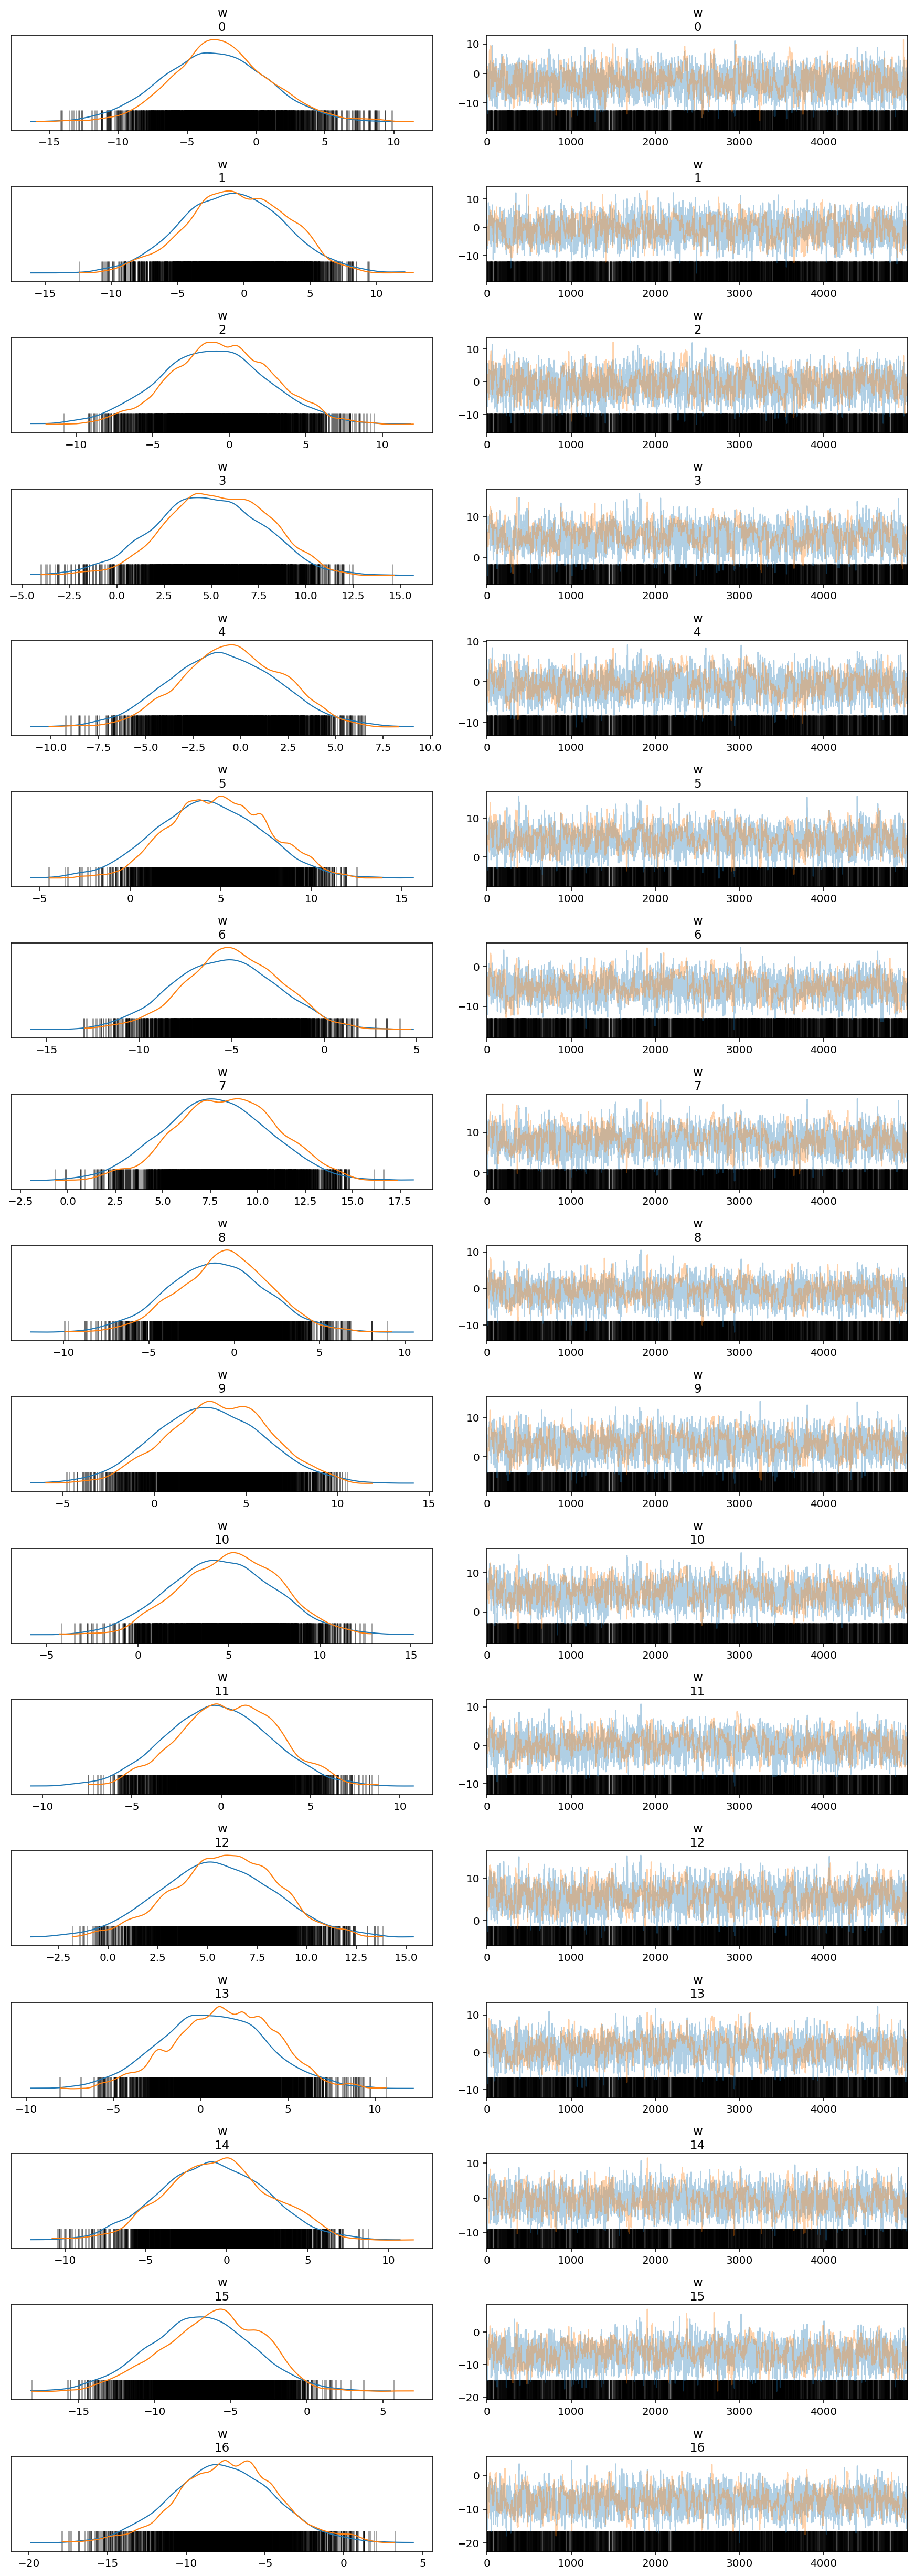

In [119]:
az.plot_trace(trace_4_7, var_names=['w'], compact=False)
plt.show()

### Code 4.77

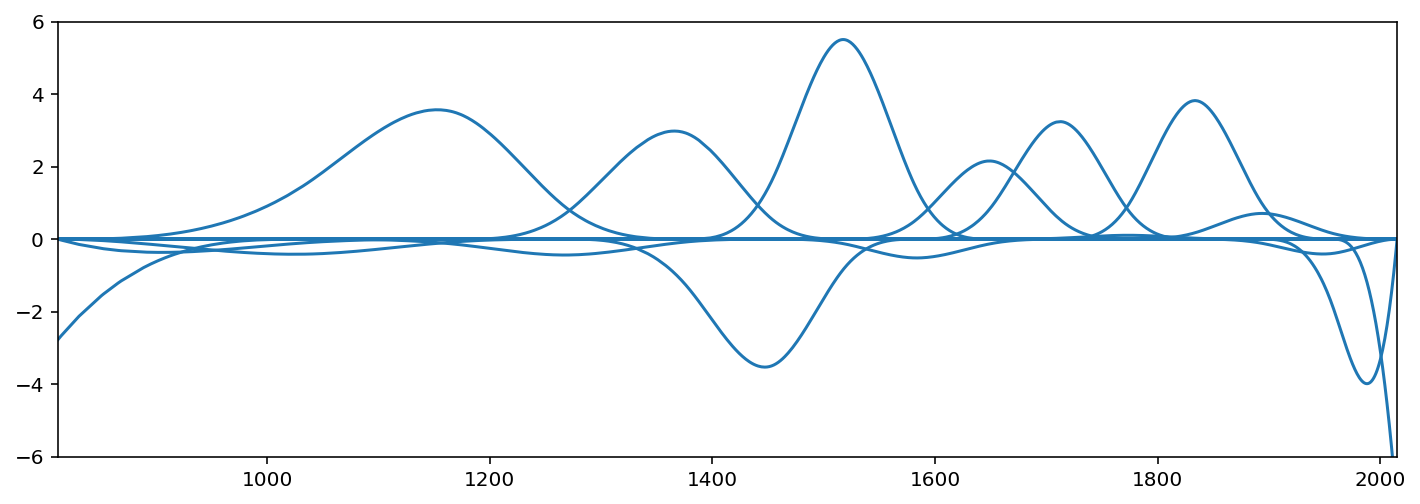

In [120]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
wp = trace_4_7[w].mean(0)
for i in range(17):
    ax.plot(d2.year, (wp[i] * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

### Code 4.78

/Users/giuliano.ferrari/Documents/Other/statistical-rethinking/.env/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


Text(0, 0.5, 'days in year')

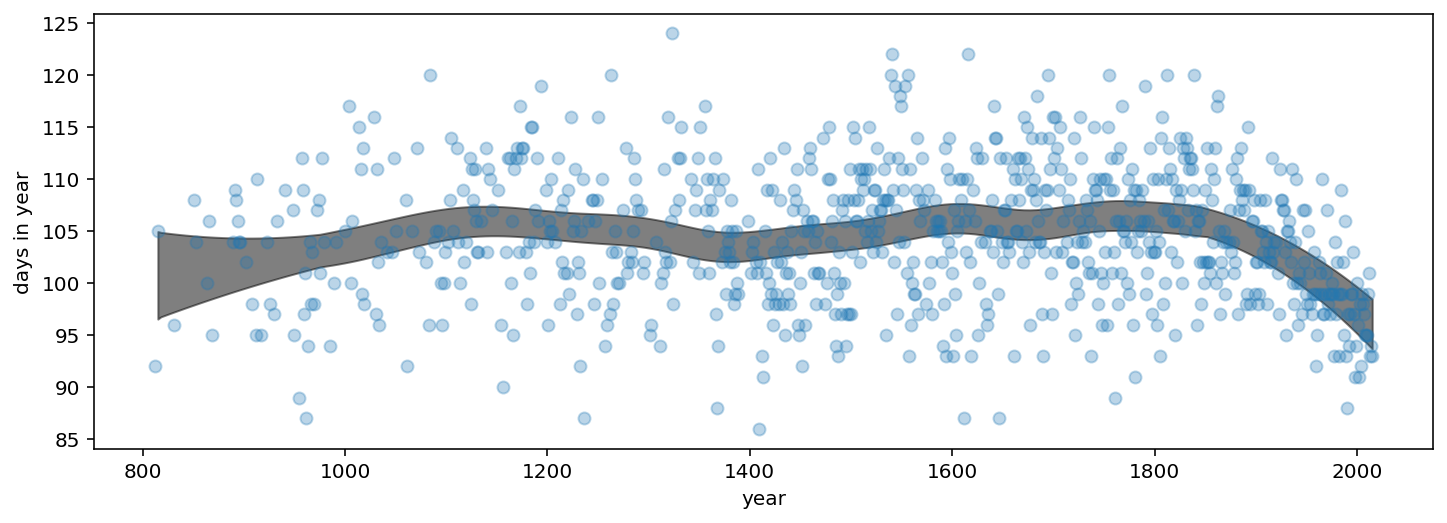

In [121]:
fig, ax = plt.subplots(figsize=(12, 4))
az.plot_hdi(d2.year, trace_4_7["mu"], color="k", ax=ax)
ax.plot(d2.year, d2.doy, "o", alpha=0.3)
ax.set_xlabel("year")
ax.set_ylabel("days in year")